In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import matplotlib.cm as cm
from matplotlib.ticker import MultipleLocator

method_path = "figs/QSSA/SIM_results/"
mechanism_name = "NH3_otomo"

case_name = "case_NH3_counterflow_KAUST"

color_arr = ('k','r','b','y','g', 'c','m')
symbol_arr = ('s','o','v','^','*')
# ─── Use generic serif font ───────────────────────────────────────────────────
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"]   = 8

# Figure 1:Validation of Non-premixed

→ Saved cases/NH3_KAUST_NP_1bar/figs/exp_vs_sim_MF_grid.pdf and cases/NH3_KAUST_NP_1bar/figs/exp_vs_sim_MF_grid.png


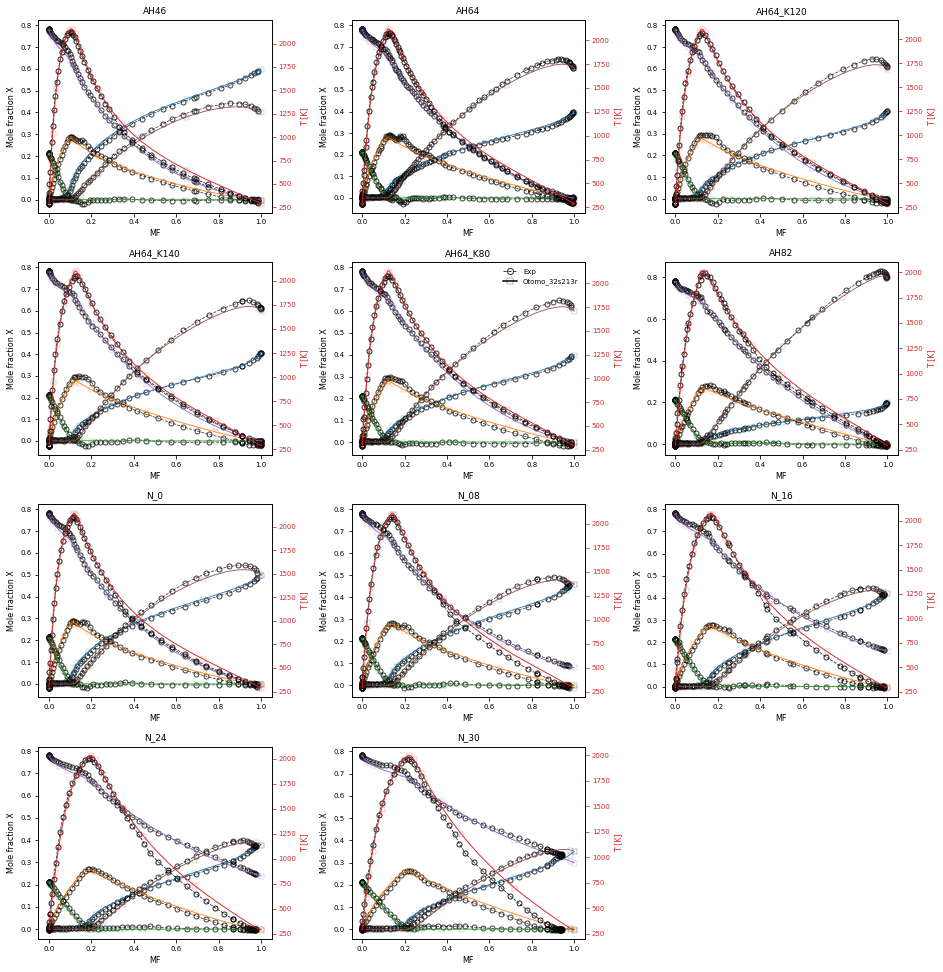

In [7]:
# %matplotlib inline
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from typing import List, Optional

# ────────────────────────── Plotting ──────────────────────────
def plot_case_grid(
    case_dir: str,
    exp_subdir: str = "Exp",
    sim_subdir: str = "Sim",
    mechs: Optional[List[str]] = None,      # e.g. ["Otomo_32s213r", "KAUST_32s243r"]
    mech_labels: Optional[List[str]] = None,
    species: Optional[List[str]] = None,    # X_ columns to plot
    fig_out: Optional[str] = None,          # path without extension; saved as .pdf and .png
):
    """
    Make a grid of panels. Each panel shows EXP scatter & SIM lines:
      - Left y-axis: selected species X_* vs MF
      - Right y-axis: T vs MF
    Assumes EXP CSVs already contain an 'MF' column.
    """
    if mechs is None:
        mechs = ["Otomo_32s213r"]
    if mech_labels is None:
        mech_labels = mechs
    if species is None:
        species = ["H2", "H2O", "O2", "N2", "NH3"]

    tab_colors = ["tab:{}".format(c) for c in ["blue","orange","green","purple","brown","pink","gray","olive","cyan"]]
    symbol_arr = ['s','^','v','*','D','X','o','P']
    line_arr   = ['-','--','-.',':']

    exp_path = os.path.join(case_dir, exp_subdir)
    sim_path = os.path.join(case_dir, sim_subdir)
    if not os.path.isdir(exp_path):
        raise FileNotFoundError("EXP directory not found: {}".format(exp_path))
    if not os.path.isdir(sim_path):
        raise FileNotFoundError("SIM directory not found: {}".format(sim_path))

    # cases present in EXP and (preferably) in at least one SIM mech
    exp_files = sorted([f for f in os.listdir(exp_path) if f.lower().endswith(".csv")])
    sim_cases = set()
    for mech in mechs:
        mdir = os.path.join(sim_path, mech)
        if os.path.isdir(mdir):
            sim_cases.update([f for f in os.listdir(mdir) if f.lower().endswith(".csv")])
    case_files = [f for f in exp_files if f in sim_cases] or exp_files

    n = len(case_files)
    cols = 3 if n >= 6 else (2 if n >= 3 else 1)
    rows = int(math.ceil(float(n) / float(cols))) if n > 0 else 1

    fig, axes = plt.subplots(rows, cols, figsize=(4.2*cols + 0.6, 3.4*rows), squeeze=False)
    center_ax = axes[min(rows-1, 1)][min(cols-1, 1)]  # central-ish panel for legend

    # Legend handles (exp + mechanisms)
    mech_handles = []
    exp_handle = Line2D([0], [0], color="k", linestyle="--", linewidth=0.9,
                        marker="o", markerfacecolor="none", markeredgecolor="k",
                        markersize=6, alpha=0.8, label="Exp")
    mech_handles.append(exp_handle)
    for j, lbl in enumerate(mech_labels):
        h = Line2D([0], [0], color="k",
                   marker=symbol_arr[j % len(symbol_arr)],
                   markerfacecolor="none", markeredgecolor="k",
                   markeredgewidth=0.25,
                   linestyle=line_arr[j % len(line_arr)],
                   markersize=6, label=lbl)
        mech_handles.append(h)

    # Panels
    for idx, fname in enumerate(case_files):
        r, c = divmod(idx, cols)
        ax = axes[r, c]
        ax_t = ax.twinx()
        title = os.path.splitext(fname)[0]

        # EXP read
        exp_csv = os.path.join(exp_path, fname)
        df_exp = pd.read_csv(exp_csv)

        if "MF" not in df_exp.columns:
            ax.set_title("{} (MF missing)".format(title), fontsize=9)
        else:
            ax.set_title(title, fontsize=9)

        # Species (left axis): EXP scatter + SIM lines
        for i, sp in enumerate(species):
            xcol = "X_{}".format(sp)
            if xcol not in df_exp.columns or "MF" not in df_exp.columns:
                continue
            color = tab_colors[i % len(tab_colors)]

            # EXP scatter
            ax.plot(
                df_exp["MF"].values, df_exp[xcol].values,
                color="k", linestyle="--", linewidth=0.8,
                marker="o", markerfacecolor="none", markeredgecolor="k",
                markersize=5, alpha=0.75
            )

            # SIM lines per mechanism
            for j, mech in enumerate(mechs):
                sim_csv = os.path.join(sim_path, mech, fname)
                if not os.path.isfile(sim_csv):
                    continue
                df_sim = pd.read_csv(sim_csv)
                if ("MF" not in df_sim.columns) or (xcol not in df_sim.columns):
                    continue
                ax.plot(
                    df_sim["MF"].values, df_sim[xcol].values,
                    color=color, linewidth=0.9,
                    marker=symbol_arr[j % len(symbol_arr)],
                    markerfacecolor="none", markeredgecolor=color,
                    markeredgewidth=0.25, markersize=5,
                    linestyle=line_arr[j % len(line_arr)],
                    markevery=max(len(df_sim)//15, 1),
                    alpha=0.95
                )

        # Temperature (right axis)
        if "MF" in df_exp.columns and "T" in df_exp.columns:
            ax_t.plot(
                df_exp["MF"].values, df_exp["T"].values,
                color="k", linestyle="--", linewidth=0.8,
                marker="o", markerfacecolor="none", markeredgecolor="k",
                markersize=5, alpha=0.85
            )
        for j, mech in enumerate(mechs):
            sim_csv = os.path.join(sim_path, mech, fname)
            if not os.path.isfile(sim_csv):
                continue
            df_sim = pd.read_csv(sim_csv)
            if ("MF" not in df_sim.columns) or ("T" not in df_sim.columns):
                continue
            ax_t.plot(
                df_sim["MF"].values, df_sim["T"].values,
                color="tab:red",
                linestyle=line_arr[j % len(line_arr)],
                linewidth=1.0, alpha=0.95,
                marker=symbol_arr[j % len(symbol_arr)],
                markerfacecolor="none", markeredgecolor="tab:red",
                markeredgewidth=0.25, markersize=5,
                markevery=max(len(df_sim)//15, 1)
            )

        ax.set_xlabel("MF", fontsize=8)
        ax.set_ylabel("Mole fraction X", fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=7)
        ax_t.set_ylabel("T [K]", fontsize=8, color="tab:red")
        ax_t.tick_params(axis='y', labelsize=7, colors="tab:red")

    # Hide unused axes
    for k in range(n, rows*cols):
        r, c = divmod(k, cols)
        axes[r, c].axis('off')

    # Legend
    center_ax.legend(handles=mech_handles, loc="upper right", fontsize=7, frameon=False)

    plt.tight_layout()
    if fig_out is None:
        fig_out = os.path.join(case_dir, "figs", "exp_vs_sim_MF_grid")
    os.makedirs(os.path.dirname(fig_out), exist_ok=True)
    plt.savefig(fig_out + ".pdf", dpi=300)
    plt.savefig(fig_out + ".png", dpi=200)
    print("→ Saved {}.pdf and {}.png".format(fig_out, fig_out))
    plt.show()

# ─────────────────────── Params & Run (edit these) ───────────────────────
case_dir   = "cases/NH3_KAUST_NP_1bar"
exp_subdir = "Exp"
sim_subdir = "Sim"
mechs      = ["Otomo_32s213r"]          # add more as available
mech_labels = None                      # or like ["Otomo", "KAUST"]
species    = ["H2", "H2O", "O2", "N2", "NH3"]
fig_out    = os.path.join(case_dir, "figs", "exp_vs_sim_MF_grid")

# plot
plot_case_grid(case_dir, exp_subdir, sim_subdir, mechs, mech_labels, species, fig_out)


# Validation of Premixed

→ Saved cases/NH3_KAUST_NP_1bar_premixed/figs/premixed_T_grid.pdf and cases/NH3_KAUST_NP_1bar_premixed/figs/premixed_T_grid.png


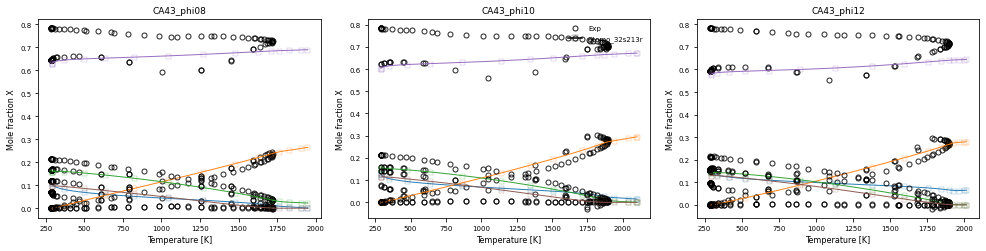

In [9]:
# %matplotlib inline
import os, math
from typing import List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ────────────────────────── Plotting ──────────────────────────
def plot_premixed_T_grid(
    case_dir: str,
    exp_subdir: str = "Exp",
    sim_subdir: str = "Sim",
    mechs: Optional[List[str]] = None,      # e.g. ["Otomo_32s213r", "KAUST_32s243r"]
    mech_labels: Optional[List[str]] = None,
    species: Optional[List[str]] = None,    # X_ columns to plot
    fig_out: Optional[str] = None,          # path without extension; saved as .pdf and .png
):
    """
    Premixed comparison — each panel shows EXP scatter & SIM lines:
      x-axis: Temperature [K]
      y-axis: selected species mole fraction X_*
    """
    if mechs is None:
        mechs = ["Otomo_32s213r"]
    if mech_labels is None:
        mech_labels = mechs
    if species is None:
        species = ["H2", "H2O", "O2", "N2", "NH3"]

    tab_colors = [f"tab:{c}" for c in ["blue","orange","green","purple","brown","pink","gray","olive","cyan"]]
    symbol_arr = ['s','^','v','*','D','X','o','P']
    line_arr   = ['-','--','-.',':']

    exp_path = os.path.join(case_dir, exp_subdir)
    sim_path = os.path.join(case_dir, sim_subdir)
    if not os.path.isdir(exp_path):
        raise FileNotFoundError(f"EXP directory not found: {exp_path}")
    if not os.path.isdir(sim_path):
        raise FileNotFoundError(f"SIM directory not found: {sim_path}")

    # cases present in EXP and (preferably) in at least one SIM mech
    exp_files = sorted([f for f in os.listdir(exp_path) if f.lower().endswith(".csv")])
    sim_cases = set()
    for mech in mechs:
        mdir = os.path.join(sim_path, mech)
        if os.path.isdir(mdir):
            sim_cases.update([f for f in os.listdir(mdir) if f.lower().endswith(".csv")])
    case_files = [f for f in exp_files if f in sim_cases] or exp_files

    n = len(case_files)
    if n == 0:
        raise RuntimeError("No EXP CSVs found.")
    # force a 1xN layout for your three cases
    rows, cols = 1, n

    fig, axes = plt.subplots(rows, cols, figsize=(4.4*cols + 0.6, 3.6*rows), squeeze=False)
    center_ax = axes[0, min(cols-1, 1)]  # central-ish panel for legend

    # Legend handles (exp + mechanisms)
    mech_handles = []
    exp_handle = Line2D([0], [0], color="k", linestyle="none",
                        marker="o", markerfacecolor="none", markeredgecolor="k",
                        markersize=5, alpha=0.9, label="Exp")
    mech_handles.append(exp_handle)
    for j, lbl in enumerate(mech_labels):
        h = Line2D([0], [0], color="k",
                   marker=symbol_arr[j % len(symbol_arr)],
                   markerfacecolor="none", markeredgecolor="k",
                   markeredgewidth=0.25,
                   linestyle=line_arr[j % len(line_arr)],
                   markersize=6, label=lbl)
        mech_handles.append(h)

    # Panels
    for idx, fname in enumerate(case_files):
        ax = axes[0, idx]
        title = os.path.splitext(fname)[0]

        # EXP read
        exp_csv = os.path.join(exp_path, fname)
        df_exp = pd.read_csv(exp_csv)
        if "T" not in df_exp.columns:
            ax.set_title(f"{title} (no T column)", fontsize=9)
            ax.axis("off")
            continue
        df_exp = df_exp.sort_values("T")

        ax.set_title(title, fontsize=9)

        # Species (single axis): EXP scatter + SIM lines vs T
        for i, sp in enumerate(species):
            xcol = "X_{}".format(sp)
            if xcol not in df_exp.columns:
                continue
            color = tab_colors[i % len(tab_colors)]

            # EXP scatter
            ax.plot(
                df_exp["T"].values, df_exp[xcol].values,
                color="k", linestyle="none",
                marker="o", markerfacecolor="none", markeredgecolor="k",
                markersize=5, alpha=0.85
            )

            # SIM lines per mechanism
            for j, mech in enumerate(mechs):
                sim_csv = os.path.join(sim_path, mech, fname)
                if not os.path.isfile(sim_csv):
                    continue
                df_sim = pd.read_csv(sim_csv)
                if ("T" not in df_sim.columns) or (xcol not in df_sim.columns):
                    continue
                df_sim = df_sim.sort_values("T")
                ax.plot(
                    df_sim["T"].values, df_sim[xcol].values,
                    color=color, linewidth=1.0,
                    marker=symbol_arr[j % len(symbol_arr)],
                    markerfacecolor="none", markeredgecolor=color,
                    markeredgewidth=0.25, markersize=5,
                    linestyle=line_arr[j % len(line_arr)],
                    markevery=max(len(df_sim)//15, 1),
                    alpha=0.95
                )

        ax.set_xlabel("Temperature [K]", fontsize=8)
        ax.set_ylabel("Mole fraction X", fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=7)

    # Hide any extra (none here, but safe)
    for k in range(n, rows*cols):
        r, c = divmod(k, cols)
        axes[r, c].axis('off')

    # Legend
    center_ax.legend(handles=mech_handles, loc="upper right", fontsize=7, frameon=False)

    plt.tight_layout()
    if fig_out is None:
        fig_out = os.path.join(case_dir, "figs", "premixed_T_grid")
    os.makedirs(os.path.dirname(fig_out), exist_ok=True)
    plt.savefig(fig_out + ".pdf", dpi=300)
    plt.savefig(fig_out + ".png", dpi=200)
    print(f"→ Saved {fig_out}.pdf and {fig_out}.png")
    plt.show()


# ─────────────────────── Params & Run (edit these) ───────────────────────
case_dir   = "cases/NH3_KAUST_NP_1bar_premixed"
exp_subdir = "Exp"
sim_subdir = "Sim"
mechs      = ["Otomo_32s213r"]                 # add more mechanisms as folders under Sim/
mech_labels = None                              # or like ["Otomo", "KAUST"]
species    = ["H2", "H2O", "O2", "N2", "NH3"]   # adjust if you want fewer/more
fig_out    = os.path.join(case_dir, "figs", "premixed_T_grid")

# plot
plot_premixed_T_grid(case_dir, exp_subdir, sim_subdir, mechs, mech_labels, species, fig_out)


# Reviewed version of Experiment Comparison 

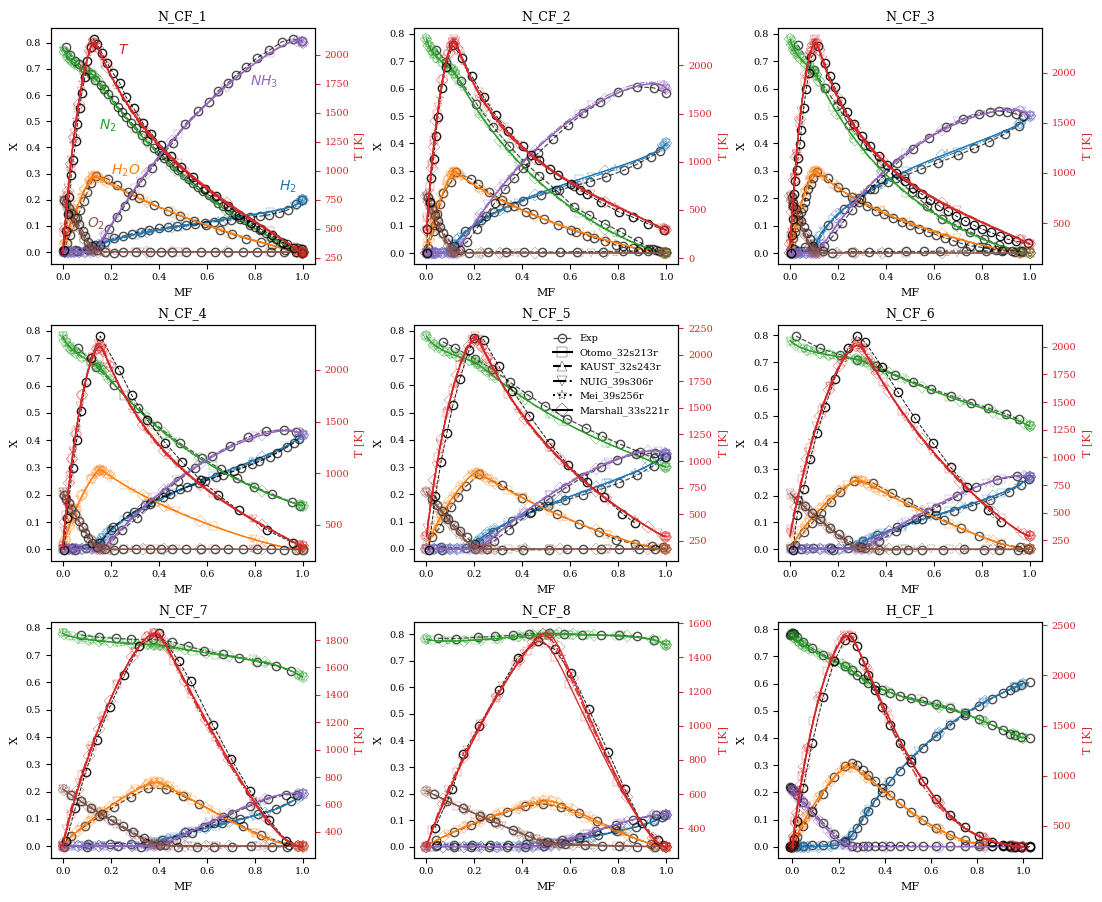

→ Saved figure at figs/validation/validation_cases_with_T_3x3.pdf


In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ─── Directories ─────────────────────────────────────────────────────────────
exp_root   = "EXP_data/N_CF_series"
sim_root   = "SIM_results"
case_name  = "case_NH3_counterflow_KAUST_Validation"
# case_name  = "case_NH3_counterflow_KAUST_Validation_mix"

mechanisms = [
    "Otomo_32s213r",
    "KAUST_32s243r",
    "NUIG_39s306r",
    "Mei_39s256r",
    # "Han_35s177r",
    "Marshall_33s221r",
]

target_case_assemble = ["N_CF_1","N_CF_2","N_CF_3","N_CF_4",
                        "N_CF_5","N_CF_6","N_CF_7","N_CF_8", "H_CF_1",]

# Use tab: color cycle for species
tab_colors = [f"tab:{c}" for c in ["blue","orange","green","purple","brown","pink","gray","olive","cyan"]]

# Markers & linestyles for mechanisms
symbol_arr = ['s','^','v','*','D','X']
line_arr   = ['-','--','-.',':']

# ─── Display names (LaTeX) and text offsets for labels ──────────────────────
species_display_names = {
    "H2":  r"$H_2$",
    "H2O": r"$H_2O$",
    "O2":  r"$O_2$",
    "N2":  r"$N_2$",
    "NH3": r"$NH_3$",
}
# small manual nudges to avoid overlaps (dx along MF, dy along Y)

text_offsets = {
    "H2":   (0.9,  0.25),
    "H2O":  (0.2,  0.31),
    "O2":   (0.1,  -0.1),
    "N2":   (0.15,  -0.3),
    "NH3":  (0.78,  0.65),
}
T_offset = (0.23, 1750)  # offset for T label on the temperature (right) axis


output_dir = "figs/validation"
os.makedirs(output_dir, exist_ok=True)

def read_two_column_csv(path):
    """Read two-column CSV (no header) and sort by x ascending."""
    df = pd.read_csv(path, header=None, names=["x","y"])
    return df.sort_values(by="x")

# ─── Figure: 3×3 grid ────────────────────────────────────────────────────────
rows, cols = 3, 3
fig, axes = plt.subplots(rows, cols, figsize=(11, 9), sharey=False)
center_ax = axes[1, 1]  # for in-panel mechanism legend

# Global marker sizes
EXP_SPECIES_S = 22
SPECIES_MS    = 6
TEMP_EXP_S    = 28
TEMP_SIM_MS   = 6
MECH_LEG_MS   = 7

for ax_idx, tc in enumerate(target_case_assemble):
    r, c = divmod(ax_idx, cols)
    ax = axes[r, c]
    ax_t = ax.twinx()  # right y-axis for Temperature

    # EXP folder
    exp_dir = os.path.join(exp_root, f"exp_{tc}")
    if not os.path.isdir(exp_dir):
        ax.set_title(f"{tc} (no EXP dir)", fontsize=8)
        ax.axis('off')
        continue

    # ── Species list (skip T in species axis; T is handled on temp axis) ─────
    species_list = []
    for fname in sorted(os.listdir(exp_dir)):
        if fname.lower().endswith(".csv"):
            sp = fname[:-4]
            if sp.upper() != "T":
                species_list.append(sp)

    # ── Plot species (EXP + SIM) on left y-axis ──────────────────────────────
    for i, species in enumerate(species_list):
        color = tab_colors[i % len(tab_colors)]

        # EXP species (sorted by x)
        exp_path = os.path.join(exp_dir, f"{species}.csv")
        if os.path.isfile(exp_path):
            try:
                df_exp = read_two_column_csv(exp_path)
                ax.plot(
                    df_exp["x"], df_exp["y"],
                    color="k",
                    linestyle="--",
                    linewidth=0.9,
                    marker="o",
                    markerfacecolor="none",
                    markeredgecolor="k",
                    markersize=6,
                    alpha=0.7
                )
            except Exception:
                pass

        # Track end position for label placement (last SIM point)
        last_x, last_y = None, None

        # SIM species for each mechanism
        for j, mech in enumerate(mechanisms):
            qssa_path = os.path.join(sim_root, case_name, mech, f"{tc}.csv")
            if not os.path.isfile(qssa_path):
                continue
            df_qssa = pd.read_csv(qssa_path)
            ycol = f"X_{species}"
            if ("MF" in df_qssa.columns) and (ycol in df_qssa.columns):
                x_vals = df_qssa["MF"].values
                if len(x_vals) == 0:
                    continue
                y_vals = df_qssa[ycol].values
                ax.plot(
                    x_vals, y_vals,
                    color=color, linewidth=0.8,
                    marker=symbol_arr[j % len(symbol_arr)],
                    markerfacecolor="none", markeredgecolor=color,
                    markeredgewidth=0.25, markersize=SPECIES_MS,
                    linestyle=line_arr[j % len(line_arr)],
                    markevery=max(len(x_vals)//15, 1),
                    alpha=0.95
                )
                last_x, last_y = x_vals[-1], y_vals[-1]

        # Add colored species label ONLY in the first subfigure (top-left)
        if ax_idx == 0 and last_x is not None and last_y is not None:
            dx, dy = text_offsets.get(species, (0.02, 0.0))
            ax.text(
                last_x + dx, last_y + dy,
                species_display_names.get(species, species),
                color=color, fontsize=10,
                va='center', ha='left', clip_on=False
            )

    # ── Temperature: EXP + SIM on right y-axis ────────────────────────────────
    exp_T = os.path.join(exp_dir, "T.csv")
    last_xt, last_yt = None, None

    if os.path.isfile(exp_T):
        try:
            df_Texp = read_two_column_csv(exp_T)
            ax_t.plot(
                df_Texp["x"], df_Texp["y"],
                color="k",
                linestyle="--",
                linewidth=0.7,
                marker="o",
                markerfacecolor="none",
                markeredgecolor="k",
                markersize=6,
                alpha=0.9
            )
        except Exception:
            pass

    for j, mech in enumerate(mechanisms):
        qssa_path = os.path.join(sim_root, case_name, mech, f"{tc}.csv")
        if not os.path.isfile(qssa_path):
            continue
        df_qssa = pd.read_csv(qssa_path)
        if ("MF" in df_qssa.columns) and ("T" in df_qssa.columns):
            x_vals = df_qssa["MF"].values
            if len(x_vals) == 0:
                continue
            y_vals = df_qssa["T"].values
            ax_t.plot(
                x_vals, y_vals,
                color="tab:red",
                linestyle=line_arr[j % len(line_arr)],
                linewidth=1.0, alpha=0.95,
                marker=symbol_arr[j % len(symbol_arr)],
                markerfacecolor="none", markeredgecolor="tab:red",
                markeredgewidth=0.25, markersize=TEMP_SIM_MS,
                markevery=max(len(x_vals)//15, 1)
            )
            last_xt, last_yt = x_vals[-1], y_vals[-1]

    # Add red "T" label ONLY in the first subfigure (use right y-axis coords)
    if ax_idx == 0 and last_xt is not None and last_yt is not None:
        dxT, dyT = T_offset
        ax_t.text(
            last_xt + dxT, last_yt + dyT,
            r"$T$", color="tab:red", fontsize=10,
            va='center', ha='left', clip_on=False
        )

    # ── Formatting ────────────────────────────────────────────────────────────
    ax.set_title(tc, fontsize=9)
    ax.set_xlabel("MF", fontsize=8)
    ax.set_ylabel("X", fontsize=8, color="black")
    ax.tick_params(axis='both', which='major', labelsize=7)

    ax_t.set_ylabel("T [K]", fontsize=8, color="tab:red")
    ax_t.tick_params(axis='y', labelsize=7, colors="tab:red")

# Hide any unused axes (if fewer than 9 cases)
for k in range(len(target_case_assemble), rows*cols):
    r, c = divmod(k, cols)
    axes[r, c].axis('off')

# ─── Mechanism legend INSIDE the center subplot ─────────────────────────────
mech_handles = []

# Experimental marker FIRST
exp_handle = Line2D([0], [0],
                    color="k",
                    linestyle="--",
                    linewidth=0.9,
                    marker="o",
                    markerfacecolor="none",
                    markeredgecolor="k",
                    markersize=6,
                    alpha=0.7,
                    label="Exp")
mech_handles.append(exp_handle)

# Mechanism markers
for j, mech in enumerate(mechanisms):
    h = Line2D([0], [0],
               color="k",
               marker=symbol_arr[j % len(symbol_arr)],
               markerfacecolor="none", markeredgecolor="k",
               markeredgewidth=0.25,
               linestyle=line_arr[j % len(line_arr)],
               markersize=MECH_LEG_MS, label=mech)
    mech_handles.append(h)

# Legend without title and without frame
center_ax.legend(handles=mech_handles,
                 loc="upper right", fontsize=7,
                 frameon=False)

plt.tight_layout()
out_file = os.path.join(output_dir, "validation_cases_with_T_3x3.pdf")
plt.savefig(out_file, dpi=300)
plt.show()

print(f"→ Saved figure at {out_file}")




# Figure 2: Plot comparison of Mechanism :
 Zst = 0.10932384533379182
## 后续考虑加上Zst line

/home/zhuxu21/.local/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


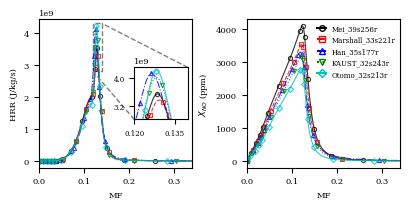

→ Saved small HRR / NO figure with zoom at: figs/validation/sim_HRR_and_NO_small_with_zoom.pdf


In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.ticker import MaxNLocator  # ← needed for reducing tick numbers

# ─── Use generic serif font and set base font size to 6 ────────────────────────
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"]   = 6

# ─── User‐adjustable settings ──────────────────────────────────────────────────

# 1) Root of all SIMULATION folders:
method_path = "SIM_results"

# 2) Which “case_name” subfolder to look under:
case_name = "case_NH3_counterflow_KAUST"

# 3) The list of mechanism‐folder names you want to compare:
mechanisms = [
    "Mei_39s256r",
    "Marshall_33s221r",
    "Han_35s177r",
    "KAUST_32s243r",
    "Otomo_32s213r",
]

# 4) The single target_case to use:
target_case = "N_CF_1"

# 5) Marker symbols to cycle through for each mechanism:
symbol_arr = ['o', 's', '^', 'v', 'D']

# 6) Colors to cycle through for each mechanism:
color_arr = ['k', 'r', 'b', 'g', 'c', 'm', 'y']

# 7) Line styles to cycle through for each mechanism:
line_arr = ['-', '--', '-.', ':']

# 8) Where to dump the figure:
output_dir = "figs/validation"
os.makedirs(output_dir, exist_ok=True)


# ─── Prepare 2×1 subplot (width = 192 pt ≈ 2.667 in) ──────────────────────────
fig, (ax_left, ax_right) = plt.subplots(
    1, 2,
    figsize=(4, 2),
    sharex=True
)

# Plot HRR on the left and NO on the right
for j, mech in enumerate(mechanisms):
    mech_color     = color_arr[j % len(color_arr)]
    mech_marker    = symbol_arr[j % len(symbol_arr)]
    mech_linestyle = line_arr[j % len(line_arr)]

    sim_path = os.path.join(
        method_path, case_name, mech, f"{target_case}.csv"
    )
    if not os.path.isfile(sim_path):
        continue

    df_sim = pd.read_csv(sim_path)
    if "MF" not in df_sim.columns:
        continue

    x_vals = df_sim["MF"]

    # ─── Left subplot: HRR only ────────────────────────────────────────────────
    if "HRR" in df_sim.columns:
        y_hrr = df_sim["HRR"]
        ax_left.plot(
            x_vals,
            y_hrr,
            color=mech_color,
            linewidth=0.8,
            alpha=0.8,
            marker=mech_marker,
            markerfacecolor="none",
            markeredgecolor=mech_color,
            markeredgewidth=0.8,
            linestyle=mech_linestyle,
            markersize=3,
            markevery=max(len(x_vals)//20, 1),
            label=""  # no label here
        )

    # ─── Right subplot: X_NO * 1e6 (ppm) ──────────────────────────────────────
    if "X_NO" in df_sim.columns:
        y_no = df_sim["X_NO"] * 1e6
        ax_right.plot(
            x_vals,
            y_no,
            color=mech_color,
            linewidth=0.8,
            alpha=0.8,
            marker=mech_marker,
            markerfacecolor="none",
            markeredgecolor=mech_color,
            markeredgewidth=0.8,
            linestyle=mech_linestyle,
            markersize=3,
            markevery=max(len(x_vals)//20, 1),
            label=""  # no label here
        )


# ─── Add inset zoom on HRR (MF between 0.12 and 0.145, HRR between 2.8e9 and 3.9e9) ─
axins = inset_axes(
    ax_left,
    width="35%",
    height="35%",
    loc="center right",
    borderpad=0.5
)
for j, mech in enumerate(mechanisms):
    mech_color     = color_arr[j % len(color_arr)]
    mech_marker    = symbol_arr[j % len(symbol_arr)]
    mech_linestyle = line_arr[j % len(line_arr)]

    sim_path = os.path.join(
        method_path, case_name, mech, f"{target_case}.csv"
    )
    if not os.path.isfile(sim_path):
        continue

    df_sim = pd.read_csv(sim_path)
    if "MF" not in df_sim.columns or "HRR" not in df_sim.columns:
        continue

    x_vals = df_sim["MF"]
    y_hrr = df_sim["HRR"]

    axins.plot(
        x_vals,
        y_hrr,
        color=mech_color,
        linewidth=0.8,
        alpha=0.8,
        marker=mech_marker,
        markerfacecolor="none",
        markeredgecolor=mech_color,
        markeredgewidth=0.8,
        linestyle=mech_linestyle,
        markersize=3,
        markevery=max(len(x_vals)//20, 1)
    )

# Set zoomed‐in limits
axins.set_xlim(0.12, 0.14)
axins.set_ylim(2.8e9, 4.3e9)

# Reduce number of ticks to at most 3 on each axis
axins.xaxis.set_major_locator(MaxNLocator(nbins=2))
axins.yaxis.set_major_locator(MaxNLocator(nbins=2))

# Reduce the font size of these tick labels
axins.tick_params(axis='both', which='major', labelsize=5)

# Draw dashed connectors instead of solid
mark_inset(
    ax_left,
    axins,
    loc1=3,
    loc2=1,
    fc="none",
    ec="0.5",
    ls="--"  # ← dashed connector lines
)


ax_left.set_xlabel("MF", fontsize=6)
ax_right.set_xlabel("MF", fontsize=6)

ax_left.set_ylabel("HRR (J/kg/s)", fontsize=6)
ax_left.tick_params(axis='both', which='major', labelsize=6)
ax_left.set_xlim(0, 0.34)

ax_right.set_ylabel(r"$X_{NO}$ (ppm)", fontsize=6)
ax_right.tick_params(axis='both', which='major', labelsize=6)
ax_right.set_xlim(0, 0.34)


# ─── Build legend inside right subplot ─────────────────────────────────────────
legend_handles = []
for j, mech in enumerate(mechanisms):
    mech_color     = color_arr[j % len(color_arr)]
    mech_marker    = symbol_arr[j % len(symbol_arr)]
    mech_linestyle = line_arr[j % len(line_arr)]
    h = Line2D(
        [0], [0],
        color=mech_color,
        marker=mech_marker,
        markerfacecolor="none",
        markeredgecolor=mech_color,
        linestyle=mech_linestyle,
        markersize=4,
        label=mech
    )
    legend_handles.append(h)

ax_right.legend(
    handles=legend_handles,
    fontsize=5,
    loc="upper right",
    framealpha=0,
    borderpad=0.2,
    handlelength=1.2
)

plt.tight_layout(pad=0.6)

# ─── Save figure ───────────────────────────────────────────────────────────────
out_file = os.path.join(output_dir, "sim_HRR_and_NO_small_with_zoom.pdf")
plt.savefig(out_file, dpi=300)
plt.show()
plt.close()

print(f"→ Saved small HRR / NO figure with zoom at: {out_file}")


# Test the sensitivity of the mechanism on NH2!

/home/zhuxu21/.local/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


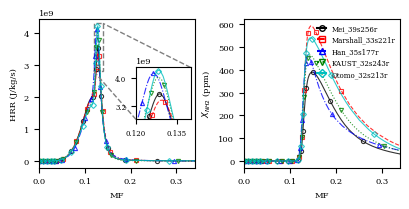

→ Saved small HRR / NH2 figure with zoom at: figs/validation/sim_HRR_and_NH2_small_with_zoom.pdf


In [138]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.ticker import MaxNLocator  # ← needed for reducing tick numbers

# ─── Use generic serif font and set base font size to 6 ────────────────────────
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"]   = 6

# ─── User‐adjustable settings ──────────────────────────────────────────────────

# 1) Root of all SIMULATION folders:
method_path = "SIM_results"

# 2) Which “case_name” subfolder to look under:
case_name = "case_NH3_counterflow_KAUST"

# 3) The list of mechanism‐folder names you want to compare:
mechanisms = [
    "Mei_39s256r",
    "Marshall_33s221r",
    "Han_35s177r",
    "KAUST_32s243r",
    "Otomo_32s213r",
]

# 4) The single target_case to use:
target_case = "N_CF_1"

# 5) Marker symbols to cycle through for each mechanism:
symbol_arr = ['o', 's', '^', 'v', 'D']

# 6) Colors to cycle through for each mechanism:
color_arr = ['k', 'r', 'b', 'g', 'c', 'm', 'y']

# 7) Line styles to cycle through for each mechanism:
line_arr = ['-', '--', '-.', ':']

# 8) Where to dump the figure:
output_dir = "figs/validation"
os.makedirs(output_dir, exist_ok=True)


# ─── Prepare 2×1 subplot (width = 192 pt ≈ 2.667 in) ──────────────────────────
fig, (ax_left, ax_right) = plt.subplots(
    1, 2,
    figsize=(4, 2),
    sharex=True
)

# Plot HRR on the left and NH2 on the right
for j, mech in enumerate(mechanisms):
    mech_color     = color_arr[j % len(color_arr)]
    mech_marker    = symbol_arr[j % len(symbol_arr)]
    mech_linestyle = line_arr[j % len(line_arr)]

    sim_path = os.path.join(
        method_path, case_name, mech, f"{target_case}.csv"
    )
    if not os.path.isfile(sim_path):
        continue

    df_sim = pd.read_csv(sim_path)
    if "MF" not in df_sim.columns:
        continue

    x_vals = df_sim["MF"]

    # ─── Left subplot: HRR only ────────────────────────────────────────────────
    if "HRR" in df_sim.columns:
        y_hrr = df_sim["HRR"]
        ax_left.plot(
            x_vals,
            y_hrr,
            color=mech_color,
            linewidth=0.8,
            alpha=0.8,
            marker=mech_marker,
            markerfacecolor="none",
            markeredgecolor=mech_color,
            markeredgewidth=0.8,
            linestyle=mech_linestyle,
            markersize=3,
            markevery=max(len(x_vals)//20, 1),
            label=""  # no label here
        )

    # ─── Right subplot: X_NH2 * 1e6 (ppm) ──────────────────────────────────────
    if "X_NH2" in df_sim.columns:
        y_no = df_sim["X_NH2"] * 1e6
        ax_right.plot(
            x_vals,
            y_no,
            color=mech_color,
            linewidth=0.8,
            alpha=0.8,
            marker=mech_marker,
            markerfacecolor="none",
            markeredgecolor=mech_color,
            markeredgewidth=0.8,
            linestyle=mech_linestyle,
            markersize=3,
            markevery=max(len(x_vals)//20, 1),
            label=""  # no label here
        )


# ─── Add inset zoom on HRR (MF between 0.12 and 0.145, HRR between 2.8e9 and 3.9e9) ─
axins = inset_axes(
    ax_left,
    width="35%",
    height="35%",
    loc="center right",
    borderpad=0.5
)
for j, mech in enumerate(mechanisms):
    mech_color     = color_arr[j % len(color_arr)]
    mech_marker    = symbol_arr[j % len(symbol_arr)]
    mech_linestyle = line_arr[j % len(line_arr)]

    sim_path = os.path.join(
        method_path, case_name, mech, f"{target_case}.csv"
    )
    if not os.path.isfile(sim_path):
        continue

    df_sim = pd.read_csv(sim_path)
    if "MF" not in df_sim.columns or "HRR" not in df_sim.columns:
        continue

    x_vals = df_sim["MF"]
    y_hrr = df_sim["HRR"]

    axins.plot(
        x_vals,
        y_hrr,
        color=mech_color,
        linewidth=0.8,
        alpha=0.8,
        marker=mech_marker,
        markerfacecolor="none",
        markeredgecolor=mech_color,
        markeredgewidth=0.8,
        linestyle=mech_linestyle,
        markersize=3,
        markevery=max(len(x_vals)//20, 1)
    )

# Set zoomed‐in limits
axins.set_xlim(0.12, 0.14)
axins.set_ylim(2.8e9, 4.3e9)

# Reduce number of ticks to at most 3 on each axis
axins.xaxis.set_major_locator(MaxNLocator(nbins=2))
axins.yaxis.set_major_locator(MaxNLocator(nbins=2))

# Reduce the font size of these tick labels
axins.tick_params(axis='both', which='major', labelsize=5)

# Draw dashed connectors instead of solid
mark_inset(
    ax_left,
    axins,
    loc1=3,
    loc2=1,
    fc="none",
    ec="0.5",
    ls="--"  # ← dashed connector lines
)


ax_left.set_xlabel("MF", fontsize=6)
ax_right.set_xlabel("MF", fontsize=6)

ax_left.set_ylabel("HRR (J/kg/s)", fontsize=6)
ax_left.tick_params(axis='both', which='major', labelsize=6)
ax_left.set_xlim(0, 0.34)

ax_right.set_ylabel(r"$X_{NH2}$ (ppm)", fontsize=6)
ax_right.tick_params(axis='both', which='major', labelsize=6)
ax_right.set_xlim(0, 0.34)


# ─── Build legend inside right subplot ─────────────────────────────────────────
legend_handles = []
for j, mech in enumerate(mechanisms):
    mech_color     = color_arr[j % len(color_arr)]
    mech_marker    = symbol_arr[j % len(symbol_arr)]
    mech_linestyle = line_arr[j % len(line_arr)]
    h = Line2D(
        [0], [0],
        color=mech_color,
        marker=mech_marker,
        markerfacecolor="none",
        markeredgecolor=mech_color,
        linestyle=mech_linestyle,
        markersize=4,
        label=mech
    )
    legend_handles.append(h)

ax_right.legend(
    handles=legend_handles,
    fontsize=5,
    loc="upper right",
    framealpha=0,
    borderpad=0.2,
    handlelength=1.2
)

plt.tight_layout(pad=0.6)

# ─── Save figure ───────────────────────────────────────────────────────────────
out_file = os.path.join(output_dir, "sim_HRR_and_NH2_small_with_zoom.pdf")
plt.savefig(out_file, dpi=300)
plt.show()
plt.close()

print(f"→ Saved small HRR / NH2 figure with zoom at: {out_file}")


# Figure 3 Effect of mechanism on the reconstruction 

mechanisms = [
    "Otomo_32s213r",
    # "KAUST_32s243r",
    # "Mei_39s256r",
    "Han_35s177r",
    # "Marshall_33s221r"
]

 Zst = 0.10932384533379182
## 后续考虑加上Zst line

<ipython-input-7-e36565b99df4>:104: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_top_r.set_ylim(ylims_top[col])
<ipython-input-7-e36565b99df4>:104: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_top_r.set_ylim(ylims_top[col])
<ipython-input-7-e36565b99df4>:104: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_top_r.set_ylim(ylims_top[col])
<ipython-input-7-e36565b99df4>:104: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_top_r.set_ylim(ylims_top[col])


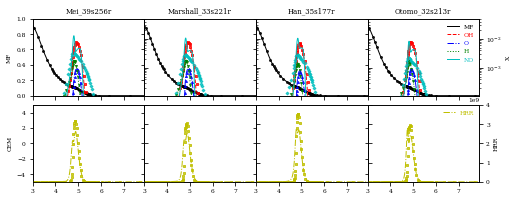

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ─── Use generic serif font and set base font size to 6 ────────────────────────
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"]   = 6

# ─── User‐adjustable settings ──────────────────────────────────────────────────
data_path   = "SIM_results"
case_folder = "case_NH3_counterflow_KAUST"
mechanisms  = [
    "Mei_39s256r",
    "Marshall_33s221r",
    "Han_35s177r",
    # "KAUST_32s243r",
    "Otomo_32s213r",
]
title_names = mechanisms

target_case = "N_CF_2"

# x‐range for all subplots
xlim = [3, 7.9]

# Dynamic lists of species/columns to plot
cols_1 = ['MF', 'X_OH', 'X_O', 'X_H', 'X_NO']
cols_3 = ['CEM','HRR']

# plot styling arrays
color_arr  = ['k', 'r', 'b', 'g', 'c', 'm', 'y']
symbol_arr = ['o', 's', '^', 'v', 'D']
line_arr   = ['-', '--', '-.', ':']

# ─── y‐limits for each variable ────────────────────────────────────────────────
ylims_top = {
    'MF':   (0.0, 1.0),
    'X_OH': (1.1e-4, 5e-2),
    'X_O':  (1.1e-4, 5e-2),
    'X_H':  (1.1e-4, 5e-2),
    'X_NO': (1.1e-4, 5e-2),
}
ylims_middle = {
    'CEM': (-5, 5),
    'HRR': (0, 4e9),
}

# ─── Prepare figure ───────────────────────────────────────────────────────────
n = len(mechanisms)
fig, axs = plt.subplots(2, n,
                       figsize=(2*n, 3),
                       sharex=True,
                       sharey='row')

if n == 1:
    axs = axs[:, np.newaxis]

for j, mech in enumerate(mechanisms):
    ax_top   = axs[0, j]
    ax_top_r = ax_top.twinx()
    ax_mid   = axs[1, j]
    ax_mid_r = ax_mid.twinx()

    ax_top.set_title(title_names[j], fontsize=7)

    # ─── Read SIM data ────────────────────────────────────────────────────────
    sim_csv = os.path.join(data_path, case_folder, mech, f"{target_case}.csv")
    if not os.path.isfile(sim_csv):
        print(f"SIM file not found: {sim_csv}")
        continue
    df_sim = pd.read_csv(sim_csv)
    grid   = df_sim['grid'] * 1000  # mm

    # ─── Read QSSA data ───────────────────────────────────────────────────────
    qssa_csv = os.path.join("figs", "QSSA",
                             data_path, case_folder,
                             target_case, mech,
                             "predicted_X.csv")
    df_qssa = pd.read_csv(qssa_csv) if os.path.isfile(qssa_csv) else pd.DataFrame()

    # ─── Row 1: MF & radicals ─────────────────────────────────────────────────
    for i, col in enumerate(cols_1):
        mkr = symbol_arr[i % len(symbol_arr)]
        ls  = line_arr[i % len(line_arr)]
        c   = color_arr[i % len(color_arr)]
        lbl = col.replace("X_", "")

        if col == 'MF':
            ax_top.scatter(grid[::3], df_sim[col][::3],
                           s=4, alpha=0.8, marker=mkr, color=c)
            if col in df_qssa:
                ax_top.plot(grid, df_qssa[col],
                            linestyle=ls, linewidth=1, color=c, label=lbl)
        else:
            ax_top_r.scatter(grid[::3], df_sim[col][::3],
                             s=4, alpha=0.8, marker=mkr, color=c)
            if col in df_qssa:
                ax_top_r.plot(grid, df_qssa[col],
                              linestyle=ls, linewidth=1, color=c, label=lbl)

        ax_top.set_ylim(ylims_top['MF'])
        ax_top_r.set_yscale('log')
        ax_top_r.set_ylim(ylims_top[col])

    ax_top.set_xlim(xlim); ax_top_r.set_xlim(xlim)
    if j == 0:
        ax_top.set_ylabel('MF', fontsize=6)
    else:
        ax_top.tick_params(labelleft=False)

    if j == n-1:
        ax_top_r.set_ylabel('X', fontsize=6)
        h1, l1 = ax_top.get_legend_handles_labels()
        h2, l2 = ax_top_r.get_legend_handles_labels()
        lg = ax_top_r.legend(h1 + h2, l1 + l2,
                              loc='upper right',
                              frameon=False,
                              fontsize=6)
        for txt, ln in zip(lg.get_texts(), lg.get_lines()):
            txt.set_color(ln.get_color())
    else:
        ax_top_r.tick_params(labelright=False)
    ax_top.tick_params(labelbottom=False)

    # ─── Row 2: HRR ────────────────────────────────────────────────────────────
    handles, labels = [], []
    for i, col in enumerate(cols_3):
        mkr = symbol_arr[(i + len(cols_1)) % len(symbol_arr)]
        ls  = line_arr[(i + len(cols_1)) % len(line_arr)]
        c   = color_arr[(i + len(cols_1)) % len(color_arr)]

        if col == 'HRR':
            # SIM line
            h = ax_mid_r.plot(grid, df_sim['HRR'],
                              linestyle=ls, linewidth=1, color=c)[0]
            handles.append(h); labels.append('HRR')
            # QSSA scatter
            if 'HRR' in df_qssa:
                ax_mid_r.scatter(grid[::2], df_qssa['HRR'][::2],
                                 s=4, alpha=0.8, marker=mkr, color=c)

        ax_mid.set_ylim(ylims_middle['CEM'])
        ax_mid_r.set_ylim(ylims_middle['HRR'])

    ax_mid.set_xlim(xlim); ax_mid_r.set_xlim(xlim)
    if j == 0:
        ax_mid.set_ylabel('CEM', fontsize=6)
    else:
        ax_mid.tick_params(labelleft=False)

    if j == n-1:
        ax_mid_r.set_ylabel('HRR', fontsize=6)
        lg2 = ax_mid.legend(handles, labels,
                             loc='upper right',
                             frameon=False,
                             fontsize=6)
        for txt, hnd in zip(lg2.get_texts(), lg2.legend_handles):
            txt.set_color(hnd.get_color())
    else:
        ax_mid_r.tick_params(labelright=False)
    ax_mid.tick_params(labelbottom=True)

plt.subplots_adjust(wspace=0, hspace=0.12)
plt.show()

# ─── Save the figure ───────────────────────────────────────────────────────────
fig_dir = "figs/NH3"
os.makedirs(fig_dir, exist_ok=True)
fig.savefig(
    os.path.join(fig_dir, "1D_CEQ_NH3_by_mechanism_colored.pdf"),
    dpi=300,
    bbox_inches='tight'
)


# Plot for CTM revision

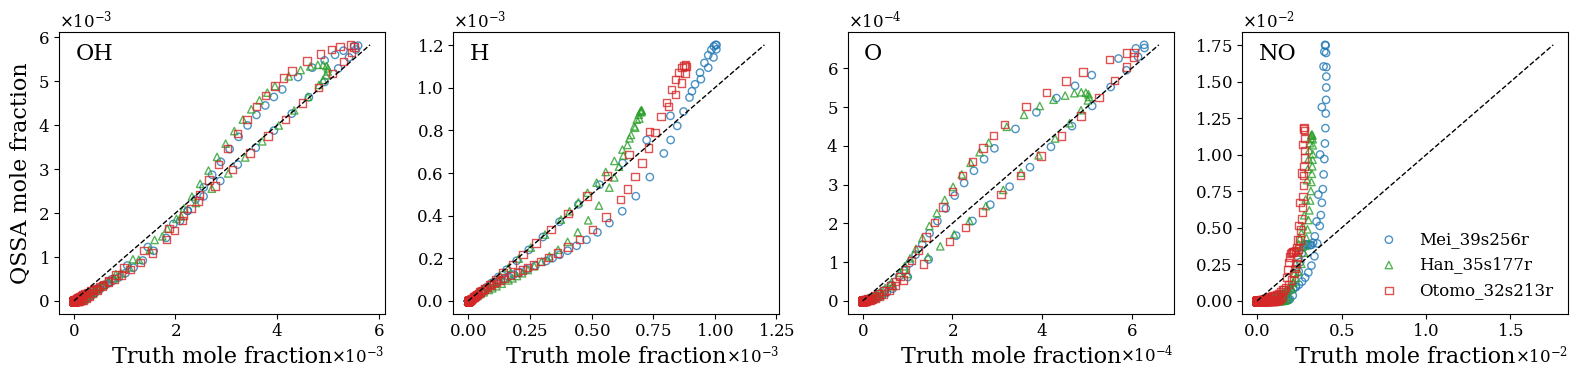

In [140]:
#!/usr/bin/env python3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# ─── Global style ─────────────────────────────────────────────────────────────
plt.rc('font', family='serif')
plt.rcParams.update({
    'font.size': 14,          # base font
    'axes.labelsize': 16,     # axis labels
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12
})

# ─── Plotting targets ────────────────────────────────────────────────────────
# species            = ['X_OH', 'X_H', 'X_O', 'X_NH2']   # 4 species → 1×4 grid
species            = ['X_OH', 'X_H', 'X_O', 'X_NO']   # 4 species → 1×4 grid

species_annotation = ['OH',   'H',   'O',   'NO']
# species_annotation = ['OH',   'H',   'O',   'NH2']
target_case = "N_CF_1"
data_path   = "SIM_results"
case_folder = "case_NH3_counterflow_KAUST"
mechanisms  = [
    "Mei_39s256r",
    # "Marshall_33s221r",
    "Han_35s177r",
    "Otomo_32s213r",
]

# fixed marker/color cycles to keep styles consistent across panels
markers = ['o', '^', 's', 'd']
colors  = ['tab:blue', 'tab:green', 'tab:red', 'tab:purple']

# ─── Figure ──────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, len(species), figsize=(16, 4), sharex=False, sharey=False)

for sp_idx, sp in enumerate(species):
    ax = axes[sp_idx]
    any_plotted = False
    all_x_max, all_y_max = [], []

    for mech_idx, mech in enumerate(mechanisms):
        # Simulation (truth)
        sim_csv = os.path.join(data_path, case_folder, mech, f"{target_case}.csv")
        if not os.path.isfile(sim_csv):
            print(f"[Skipped] Missing SIM: {sim_csv}")
            continue
        df_sim   = pd.read_csv(sim_csv)
        sim_vals = pd.to_numeric(df_sim[sp], errors='coerce')

        # QSSA prediction
        qssa_csv = os.path.join("figs", "QSSA", data_path, case_folder, target_case, mech, "predicted_X.csv")
        if not os.path.isfile(qssa_csv):
            print(f"[Skipped] Missing QSSA: {qssa_csv}")
            continue
        df_qssa   = pd.read_csv(qssa_csv)
        qssa_vals = pd.to_numeric(df_qssa[sp], errors='coerce')

        # Filter valid
        mask = sim_vals.notna() & qssa_vals.notna()
        x = sim_vals[mask]
        y = qssa_vals[mask]
        if x.empty or y.empty:
            continue

        any_plotted = True
        all_x_max.append(x.max())
        all_y_max.append(y.max())

        ax.scatter(
            x, y,
            label=mech,
            s=28,                      # ↑ marker size for readability
            marker=markers[mech_idx % len(markers)],
            facecolors='none',
            edgecolors=colors[mech_idx % len(colors)],
            alpha=0.8
        )

    # 1:1 reference line (based on plotted data)
    if any_plotted:
        m = max(max(all_x_max), max(all_y_max))
        ax.plot([0, m], [0, m], 'k--', linewidth=1)

    # Annotation
    ax.text(0.05, 0.90, species_annotation[sp_idx], transform=ax.transAxes, fontsize=16)

    # Formatting
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='both', scilimits=(0, 0))

    ax.set_xlabel('Truth mole fraction')
    if sp_idx == 0:
        ax.set_ylabel('QSSA mole fraction')

    # Legend only on the last subplot
    if sp_idx == len(species) - 1:
        ax.legend(loc='lower right', frameon=False)

plt.tight_layout()
plt.savefig("comparison_qssa_vs_truth.png", dpi=300)
plt.show()

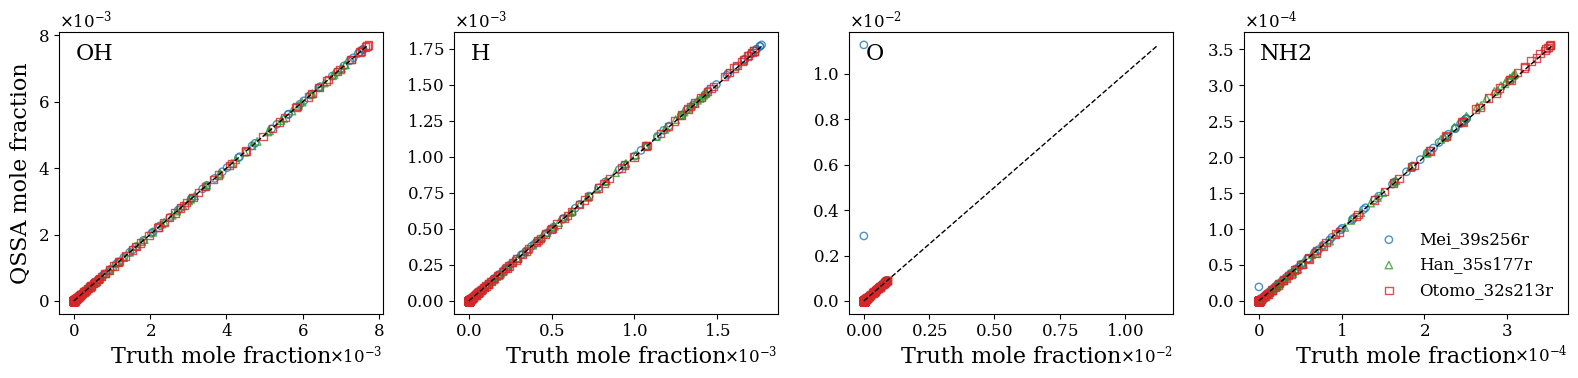

In [148]:
#!/usr/bin/env python3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# ─── Global style ─────────────────────────────────────────────────────────────
plt.rc('font', family='serif')
plt.rcParams.update({
    'font.size': 14,          # base font
    'axes.labelsize': 16,     # axis labels
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12
})

# ─── Plotting targets ────────────────────────────────────────────────────────
species            = ['X_OH', 'X_H', 'X_O', 'X_NH2']   # 4 species → 1×4 grid
# species            = ['X_OH', 'X_H', 'X_O', 'X_NO']   # 4 species → 1×4 grid

species_annotation = ['OH',   'H',   'O',   'NH2']
# species_annotation = ['OH',   'H',   'O',   'NH2']
target_case = "N_CF_5"
data_path   = "SIM_results"
case_folder = "case_NH3_counterflow_KAUST_OH"
mechanisms  = [
    "Mei_39s256r",
    # "Marshall_33s221r",
    "Han_35s177r",
    "Otomo_32s213r",
]

# fixed marker/color cycles to keep styles consistent across panels
markers = ['o', '^', 's', 'd']
colors  = ['tab:blue', 'tab:green', 'tab:red', 'tab:purple']

# ─── Figure ──────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, len(species), figsize=(16, 4), sharex=False, sharey=False)

for sp_idx, sp in enumerate(species):
    ax = axes[sp_idx]
    any_plotted = False
    all_x_max, all_y_max = [], []

    for mech_idx, mech in enumerate(mechanisms):
        # Simulation (truth)
        sim_csv = os.path.join(data_path, case_folder, mech, f"{target_case}.csv")
        if not os.path.isfile(sim_csv):
            print(f"[Skipped] Missing SIM: {sim_csv}")
            continue
        df_sim   = pd.read_csv(sim_csv)
        sim_vals = pd.to_numeric(df_sim[sp], errors='coerce')

        # QSSA prediction
        qssa_csv = os.path.join("figs", "QSSA", data_path, case_folder, target_case, mech, "predicted_X.csv")
        if not os.path.isfile(qssa_csv):
            print(f"[Skipped] Missing QSSA: {qssa_csv}")
            continue
        df_qssa   = pd.read_csv(qssa_csv)
        qssa_vals = pd.to_numeric(df_qssa[sp], errors='coerce')

        # Filter valid
        mask = sim_vals.notna() & qssa_vals.notna()
        x = sim_vals[mask]
        y = qssa_vals[mask]
        if x.empty or y.empty:
            continue

        any_plotted = True
        all_x_max.append(x.max())
        all_y_max.append(y.max())

        ax.scatter(
            x, y,
            label=mech,
            s=28,                      # ↑ marker size for readability
            marker=markers[mech_idx % len(markers)],
            facecolors='none',
            edgecolors=colors[mech_idx % len(colors)],
            alpha=0.8
        )

    # 1:1 reference line (based on plotted data)
    if any_plotted:
        m = max(max(all_x_max), max(all_y_max))
        ax.plot([0, m], [0, m], 'k--', linewidth=1)

    # Annotation
    ax.text(0.05, 0.90, species_annotation[sp_idx], transform=ax.transAxes, fontsize=16)

    # Formatting
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='both', scilimits=(0, 0))

    ax.set_xlabel('Truth mole fraction')
    if sp_idx == 0:
        ax.set_ylabel('QSSA mole fraction')

    # Legend only on the last subplot
    if sp_idx == len(species) - 1:
        ax.legend(loc='lower right', frameon=False)

plt.tight_layout()
plt.savefig("comparison_qssa_vs_truth.png", dpi=300)
plt.show()

# Supplementary figure 1

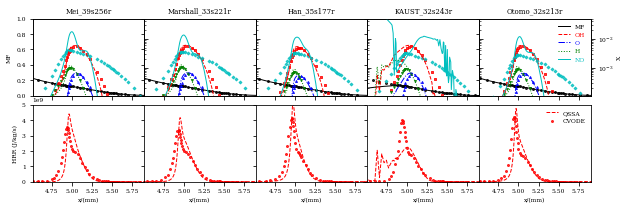

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ─── Use generic serif font and set base font size to 6 ────────────────────────
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"]   = 6

# ─── User‐adjustable settings ──────────────────────────────────────────────────
data_path   = "SIM_results"
case_folder = "case_NH3_counterflow_KAUST"
mechanisms  = [
    "Mei_39s256r",
    "Marshall_33s221r",
    "Han_35s177r",
    "KAUST_32s243r",
    "Otomo_32s213r",
]
title_names = mechanisms

target_case = "N_CF_1"

# x‐range for all subplots
xlim = [4.51,5.9]

# species for top row
cols_1 = ['MF', 'X_OH', 'X_O', 'X_H', 'X_NO']

# styling arrays
color_arr  = ['k', 'r', 'b', 'g', 'c', 'm', 'y']
symbol_arr = ['o', 's', '^', 'v', 'D']
line_arr   = ['-', '--', '-.', ':']

# ─── y‐limits ──────────────────────────────────────────────────────────────────
ylims_top = {
    'MF':   (0.0, 1.0),
    'X_OH': (1.1e-4, 5e-2),
    'X_O':  (1.1e-4, 5e-2),
    'X_H':  (1.1e-4, 5e-2),
    'X_NO': (1.1e-4, 5e-2),
}
ylims_hrr = (0, 5e9)

# ─── Prepare figure ───────────────────────────────────────────────────────────
n = len(mechanisms)
fig, axs = plt.subplots(2, n,
                        figsize=(2*n, 3),
                        sharex=True,
                        sharey=False)

if n == 1:
    axs = axs[:, np.newaxis]

for j, mech in enumerate(mechanisms):
    # top row
    ax_top   = axs[0, j]
    ax_top_r = ax_top.twinx()
    ax_top.set_title(title_names[j], fontsize=7)

    sim_csv = os.path.join(data_path, case_folder, mech, f"{target_case}.csv")
    if not os.path.isfile(sim_csv):
        print(f"SIM file not found: {sim_csv}")
        continue
    df_sim = pd.read_csv(sim_csv)
    grid   = df_sim['grid'] * 1000  # mm

    qssa_csv = os.path.join("figs", "QSSA",
                             data_path, case_folder,
                             target_case, mech,
                             "predicted_X.csv")
    df_qssa = pd.read_csv(qssa_csv) if os.path.isfile(qssa_csv) else pd.DataFrame()

    for i, col in enumerate(cols_1):
        mkr = symbol_arr[i % len(symbol_arr)]
        ls  = line_arr[i % len(line_arr)]
        c   = color_arr[i % len(color_arr)]
        lbl = col.replace("X_", "")

        if col == 'MF':
            ax_top.scatter(grid[::3], df_sim[col][::3],
                           s=4, alpha=0.8, marker=mkr, color=c)
            if col in df_qssa:
                ax_top.plot(grid, df_qssa[col],
                            linestyle=ls, linewidth=1, color=c, label=lbl)
        else:
            ax_top_r.scatter(grid[::3], df_sim[col][::3],
                             s=4, alpha=0.8, marker=mkr, color=c)
            if col in df_qssa:
                ax_top_r.plot(grid, df_qssa[col],
                              linestyle=ls, linewidth=1, color=c, label=lbl)

    ax_top.set_xlim(xlim)
    ax_top.set_ylim(ylims_top['MF'])
    ax_top_r.set_xlim(xlim)
    ax_top_r.set_yscale('log')
    ax_top_r.set_ylim(ylims_top[col])  # last col’s limits, but sharey='row' could keep consistent

    if j == 0:
        ax_top.set_ylabel('MF', fontsize=6)
    else:
        ax_top.tick_params(labelleft=False)
    if j == n-1:
        ax_top_r.set_ylabel('X', fontsize=6)
        h1, l1 = ax_top.get_legend_handles_labels()
        h2, l2 = ax_top_r.get_legend_handles_labels()
        lg = ax_top_r.legend(h1 + h2, l1 + l2,
                              loc='upper right',
                              frameon=False,
                              fontsize=6)
        for txt, ln in zip(lg.get_texts(), lg.get_lines()):
            txt.set_color(ln.get_color())
    else:
        ax_top_r.tick_params(labelright=False)
    ax_top.tick_params(labelbottom=False)

    # bottom row — only HRR
    ax_bot = axs[1, j]
    ax_bot.set_xlim(xlim)
    ax_bot.set_ylim(ylims_hrr)

    # plot SIM HRR
    ax_bot.plot(grid, df_qssa['HRR'],
                linestyle='--', linewidth=1, color='red',
                label='QSSA')

    # plot QSSA HRR if available
    if 'HRR' in df_qssa:
        ax_bot.scatter(grid[::2], df_sim['HRR'][::2],
                       s=4, alpha=0.8, marker='o',
                       color='red', label='Truth')

    if j == 0:
        ax_bot.set_ylabel('HRR (J/kg/s)', fontsize=6)
    else:
        ax_bot.tick_params(labelleft=False)

    if j == n-1:
        ax_bot.legend(loc='upper right', frameon=False, fontsize=6)
    ax_bot.tick_params(labelbottom=True)
    ax_bot.set_xlabel('x/(mm)', fontsize=6)
    

plt.subplots_adjust(wspace=0, hspace=0.12)
plt.show()

# ─── Save the figure ───────────────────────────────────────────────────────────
fig_dir = "figs/NH3"
os.makedirs(fig_dir, exist_ok=True)
fig.savefig(
    os.path.join(fig_dir, "Supplementary_1D_CEQ_NH3_HRR_only.pdf"),
    dpi=300,
    bbox_inches='tight'
)


# Figure 5: Comparison of Adding OH 

File not found: SIM_results/case_NH3_counterflow_KAUST_ori/Otomo_32s213r/N_CF_1.csv
File not found: SIM_results/case_NH3_counterflow_KAUST_ori/Otomo_32s213r/N_CF_1.csv


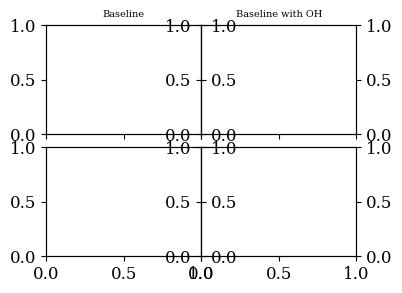

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.collections import PathCollection

# ─── Use generic serif font and set base font size to 6 ────────────────────────
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"]   = 6

# ─── User‐adjustable settings ──────────────────────────────────────────────────
data_path    = "SIM_results"
case_names   = [
    "case_NH3_counterflow_KAUST_ori",
    "case_NH3_counterflow_KAUST_OH"
]
title_names  = [
    "Baseline",
    "Baseline with OH"
]
sim_source   = case_names[0]    # always read SIM data from this folder
target_case  = "N_CF_1"
mechanism    = "Otomo_32s213r"

# x‐range for all subplots
xlim = [3, 7.9]

# Dynamic lists of species/columns to plot
cols_1 = ['MF', 'X_OH', 'X_O', 'X_H', 'X_NO']

cols_3 = ['CEM', 'HRR']

# Markers, colors, linestyles (cycled through)
symbol_arr = ['o', 's', '^', 'v', 'D']
color_arr  = ['k', 'r', 'b', 'g', 'c', 'm', 'y']
line_arr   = ['-', '--', '-.', ':']

output_dir = "figs/validation"
os.makedirs(output_dir, exist_ok=True)

# ─── User‐adjustable y‐limits for each variable ────────────────────────────────
ylims_top = {
    'MF':   (0.0, 1.0),
    'X_OH': (1.1e-4, 5e-2),
    'X_O':  (1.1e-4, 5e-2),
    'X_H':  (1.1e-4, 5e-2),
    'X_NO': (1.1e-4, 5e-2),
    'X_NH2': (1.1e-4, 5e-2),
    
}

ylims_middle = {
    'CEM': (-5, 5),
    'HRR': (0, 4.5e9),
}

# ─── Create subplots ──────────────────────────────────────────────────────────
n_cases = len(case_names)
fig, axs = plt.subplots(
    2, n_cases,
    figsize=(2 * n_cases, 3),
    sharex=True
)
if n_cases == 1:
    axs = axs[:, np.newaxis]

# ─── Loop over cases ──────────────────────────────────────────────────────────
for j, case_name in enumerate(case_names):
    ax_top   = axs[0, j]
    ax_top_r = ax_top.twinx()
    ax_mid   = axs[1, j]
    ax_mid_r = ax_mid.twinx()

    ax_top.set_title(title_names[j], fontsize=7)

    # SIM data (always from sim_source)
    sim_csv = os.path.join(data_path, sim_source, mechanism, f"{target_case}.csv")
    if not os.path.isfile(sim_csv):
        print(f"File not found: {sim_csv}")
        continue
    df_sim = pd.read_csv(sim_csv)
    grid   = df_sim['grid'] * 1000  # mm

    # QSSA data for this case
    qssa_csv = os.path.join(
        "figs", "QSSA", data_path, case_name, target_case, mechanism, "predicted_X.csv"
    )
    df_qssa = pd.read_csv(qssa_csv) if os.path.isfile(qssa_csv) else pd.DataFrame()

    # ─── Top row: MF + radicals ──────────────────────────────────────────────
    for i, col in enumerate(cols_1):
        mkr, ls, c = symbol_arr[i % len(symbol_arr)], line_arr[i % len(line_arr)], color_arr[i % len(color_arr)]
        lbl = col.replace("X_", "")

        if col == 'MF':
            if col in df_sim:
                ax_top.scatter(grid[::3], df_sim[col][::3], s=4, alpha=0.8, marker=mkr, color=c)
            if col in df_qssa:
                ax_top.plot(grid, df_qssa[col], linestyle=ls, linewidth=1, color=c, label=lbl)
        else:
            if col in df_sim:
                ax_top_r.scatter(grid[::3], df_sim[col][::3], s=4, alpha=0.8, marker=mkr, color=c)
            if col in df_qssa:
                ax_top_r.plot(grid, df_qssa[col], linestyle=ls, linewidth=1, color=c, label=lbl)

    # impose uniform top‐row limits
    ax_top.set_xlim(xlim)
    ax_top.set_ylim(ylims_top['MF'])
    ax_top_r.set_xlim(xlim)
    ax_top_r.set_yscale('log')
    # choose one of the radical y‐limits (they're identical in ylims_top)
    ax_top_r.set_ylim(ylims_top['X_OH'])

    # format left‐axis labels
    if j == 0:
        ax_top.set_ylabel('MF', fontsize=6)
        ax_top.tick_params(labelleft=True)
    else:
        ax_top.tick_params(labelleft=False)
    # format right‐axis labels + legend only on last
    if j == n_cases - 1:
        ax_top_r.set_ylabel('X', fontsize=6)
        ax_top_r.tick_params(labelright=True)
        h1, l1 = ax_top.get_legend_handles_labels()
        h2, l2 = ax_top_r.get_legend_handles_labels()
        lg = ax_top_r.legend(h1 + h2, l1 + l2, loc='upper right', frameon=False, fontsize=6)
        for text, line in zip(lg.get_texts(), lg.get_lines()):
            text.set_color(line.get_color())
    else:
        ax_top_r.tick_params(labelright=False)
    ax_top.tick_params(labelbottom=False)

    # ─── Bottom row: CEM + HRR ────────────────────────────────────────────────
    handles, labels = [], []
    for i, col in enumerate(cols_3):
        mkr = symbol_arr[(i + len(cols_1)) % len(symbol_arr)]
        ls  = line_arr[(i + len(cols_1)) % len(line_arr)]

        if col == 'CEM':
            if 'CEM' in df_sim:
                h = ax_mid.scatter(grid[::3], df_sim['CEM'][::3], s=4, alpha=0.8, marker=mkr, color='k')
                handles.append(h); labels.append('CEM')
            if 'CEM' in df_qssa:
                ax_mid.plot(grid, df_qssa['CEM'], linestyle=ls, linewidth=1, color='k')
        else:  # HRR
            if 'HRR' in df_sim:
                h = ax_mid_r.plot(grid, df_sim['HRR'], linestyle=ls, linewidth=1, color='r')[0]
                handles.append(h); labels.append('HRR')
            if 'HRR' in df_qssa:
                ax_mid_r.scatter(grid[::2], df_qssa['HRR'][::2], s=4, alpha=0.8, marker=mkr, color='r')

    # impose uniform bottom‐row limits
    ax_mid.set_xlim(xlim)
    ax_mid.set_ylim(ylims_middle['CEM'])
    ax_mid_r.set_xlim(xlim)
    ax_mid_r.set_ylim(ylims_middle['HRR'])

    # format bottom row axes
    if j == 0:
        ax_mid.set_ylabel('CEM', fontsize=6)
        ax_mid.tick_params(labelleft=True)
    else:
        ax_mid.tick_params(labelleft=False)
    if j == n_cases - 1:
        ax_mid_r.set_ylabel('HRR', fontsize=6)
        ax_mid_r.tick_params(labelright=True)
        lg2 = ax_mid.legend(handles, labels, loc='upper right', frameon=False, fontsize=6)
        for text, handle in zip(lg2.get_texts(), lg2.legend_handles):
            c = handle.get_color() if hasattr(handle, 'get_color') else handle.get_facecolor()[0]
            text.set_color(c)
    else:
        ax_mid_r.tick_params(labelright=False)
    ax_mid.tick_params(labelbottom=True)

plt.subplots_adjust(wspace=0, hspace=0.12)
plt.show()

# ─── Save the figure ───────────────────────────────────────────────────────────
fig_dir = "figs/NH3"
os.makedirs(fig_dir, exist_ok=True)
fig.savefig(
    os.path.join(fig_dir, "1D_CEQ_NH3_combine_expanded_comparison_with_OH.pdf"),
    dpi=300,
    bbox_inches='tight'
)

# Figure 4: Reconstruction over space

→ Saved figure at: figs/NH3/1D_CEQ_NH3_combine_expanded.pdf


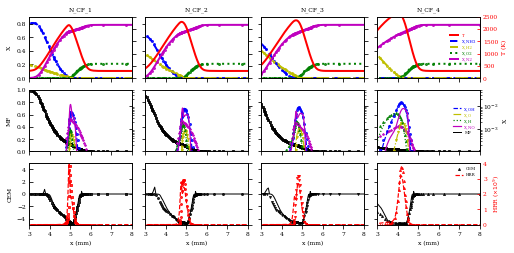

In [7]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.collections import PathCollection

# ─── User‐adjustable settings ──────────────────────────────────────────────────

# 1) Root of all SIMULATION folders:
method_path = "SIM_results"

# 2) The “case_name” subfolder to look under:
case_name = "case_NH3_counterflow_KAUST"

# 3) Fixed mechanism folder name:
mech = "Otomo_32s213r"

# 4) The list of target cases to use:
target_case_assemble = [
    # 'N_CF_0',
    'N_CF_1',
    'N_CF_2',
    'N_CF_3',
    'N_CF_4',
    
    # (feel free to re‐enable others if needed)
]

# 5) Display names for each panel (can be identical to target_case names):
target_name_assemble = [
    # 'N_CF_0',
    'N_CF_1',
    'N_CF_2',
    'N_CF_3',
    'N_CF_4',
    
]

# 6) x‐ranges for each target case:
x_range_assemble = [
    [3, 8],
    [3, 8],
    [3, 8],
    [3, 8],
    [3, 8],
]

# 7) Line styles, colors, markers (cycled through):
line_arr = ('-','--','-.',':')
color_arr = ('k','b','y','g','m')
# color_arr = ('k','r','b','y',)

symbol_arr = ('s','o','v','^','*')

# ###################### Plot FIGURE RECONSTRUCT SPACE ######################
fig, axs = plt.subplots(
    3,
    len(target_case_assemble),
    figsize=(1.8 * len(target_case_assemble), 3.5),
    sharex=True
)

# Ensure axs is always 2D even if there's only one column
if len(target_case_assemble) == 1:
    axs = axs[:, np.newaxis]

# Columns to plot in each row
cols_1 = ['T',    'X_NH3', 'X_H2', 'X_O2', 'X_N2']
cols_2 = ['MF',   'X_OH',  'X_O',  'X_H',  'X_NO']
cols_3 = ['CEM',  'HRR']

# ─── User‐adjustable y‐limits for each variable ────────────────────────────────
cols_2_range = {
    'MF':   (0.0, 1.0),       # MF is always linear [0,1]
    'X_OH': (1.1e-4, 5e-2),
    'X_O':  (1.1e-4, 5e-2),
    'X_H':  (1.1e-4, 5e-2),
    'X_NO': (1.1e-4, 5e-2),
}

cols_3_range = {
    'CEM': (-5, 5),
    'HRR': (0, 4e9),
}


for j, target_case in enumerate(target_case_assemble):
    # ─── Read SIM (original) data for this mechanism ───────────────────────────
    sim_csv_path = os.path.join(method_path, case_name, mech, f"{target_case}.csv")
    if not os.path.isfile(sim_csv_path):
        print(f"  → File not found: {sim_csv_path}")
        continue

    df_sim = pd.read_csv(sim_csv_path)
    grid = df_sim['grid'].to_numpy() * 1000  # convert to mm

    # ─── Read reconstructed (QSSA) data for this mechanism ────────────────────
    qssa_path = os.path.join("figs", "QSSA", method_path, case_name, target_case, mech, "predicted_X.csv")
    if os.path.isfile(qssa_path):
        df_qssa = pd.read_csv(qssa_path)
    else:
        df_qssa = pd.DataFrame()

    # ─── Row 1: Plot cols_1 ──────────────────────────────────────────────────
    ax1 = axs[0, j]
    ax2 = ax1.twinx()

    for i, col in enumerate(cols_1):
        ls = line_arr[i % len(line_arr)]
        c = 'red' if col == 'T' else color_arr[i % len(color_arr)]

        if col == 'T':
            # Plot temperature on the right axis
            if 'T' in df_sim.columns:
                ax2.plot(grid,
                         df_sim['T'].to_numpy(),
                         linestyle=ls, linewidth=2,
                         color='red',
                         label='T')
        else:
            # Plot QSSA (reconstructed) on left, SIM scatter for comparison
            if col in df_qssa.columns:
                ax1.plot(grid,
                         df_qssa[col].to_numpy(),
                         linestyle=ls, linewidth=2,
                         color=c,
                         label=col)
            if col in df_sim.columns:
                ax1.scatter(grid[::3],
                            df_sim[col].to_numpy()[::3],
                            s=4, alpha=0.8,
                            marker='o',
                            color=c)

    # Set x and y limits for row 1
    ax1.set_xlim(x_range_assemble[j])
    ax2.set_xlim(x_range_assemble[j])
    ax1.set_ylim(0, 0.9)     # still hard‐coded for X‐species in row1
    ax2.set_ylim(0, 2500)

    # Y‐labeling and ticks for row 1
    if j == 0:
        ax1.set_ylabel('X', fontsize=6, color='black')
        ax1.tick_params(axis='y', labelleft=True, labelright=False, direction='in')
        ax2.tick_params(axis='y', labelleft=False, labelright=False)
    elif j == len(target_case_assemble) - 1:
        ax2.set_ylabel('T (K)', fontsize=6, color='red')
        # Combined legend inside the last panel
        handles2, labels2 = ax2.get_legend_handles_labels()
        handles1, labels1 = ax1.get_legend_handles_labels()
        combined_handles = handles2 + handles1
        combined_labels = labels2 + labels1
        legend = ax1.legend(combined_handles,
                            combined_labels,
                            loc='center right',
                            # bbox_to_anchor=(0.55, 0.55),
                            frameon=False,
                            fontsize=4)
        for text, line in zip(legend.get_texts(), legend.get_lines()):
            text.set_color(line.get_color())
        ax2.tick_params(axis='y', labelleft=False, colors='red', direction='in', labelright=True)
        ax1.tick_params(axis='y', labelleft=False, labelright=False)
    else:
        ax2.tick_params(axis='y', labelleft=False, labelright=False)
        ax1.tick_params(axis='y', labelleft=False, labelright=False)

    ax1.tick_params(axis='x', labelbottom=False)
    ax1.set_title(f"{target_name_assemble[j]}", fontsize=6)

    # ─── Row 2: Plot cols_2 ──────────────────────────────────────────────────
    ax1_2 = axs[1, j]
    ax2_2 = ax1_2.twinx()

    for i, col in enumerate(cols_2):
        ls = line_arr[i % len(line_arr)]
        # MF on left axis (black), all others on right axis (colored)
        if col == 'MF':
            if 'MF' in df_qssa.columns:
                ax1_2.plot(grid,
                           df_qssa['MF'].to_numpy(),
                           linestyle=ls, linewidth=1,
                           color='black',
                           label='MF')
            if 'MF' in df_sim.columns:
                ax1_2.scatter(grid,
                              df_sim['MF'].to_numpy(),
                              s=4, alpha=0.8,
                              marker=symbol_arr[i % len(symbol_arr)],
                              color='black')
        else:
            c = color_arr[i % len(color_arr)]
            if col in df_sim.columns:
                ax2_2.scatter(grid[::3],
                              df_sim[col].to_numpy()[::3],
                              s=4, alpha=0.8,
                              marker=symbol_arr[i % len(symbol_arr)],
                              color=c)
            if col in df_qssa.columns:
                ax2_2.plot(grid,
                           df_qssa[col].to_numpy(),
                           linestyle=ls, linewidth=1.2,
                           color=c,
                           label=col)

    # Set axis limits and log scale for row 2 using the dictionaries:
    ax1_2.set_xlim(x_range_assemble[j])
    ax2_2.set_xlim(x_range_assemble[j])

    # Left y‐limit for MF:
    y_min, y_max = cols_2_range['MF']
    ax1_2.set_ylim(y_min, y_max)

    # Right y‐limit for all other X‐species:
    # We know all non‐MF species share the same range in cols_2_range
    # (X_OH, X_O, X_H, X_NO). So just pick one of them:
    y_min2, y_max2 = cols_2_range['X_OH']
    ax2_2.set_ylim(y_min2, y_max2)
    ax2_2.set_yscale('log')

    # Y‐labeling and ticks for row 2
    if j == 0:
        ax1_2.set_ylabel('MF', fontsize=6, color='black')
        ax1_2.tick_params(axis='y', labelleft=True, colors='black', direction='in', labelright=False)
        ax2_2.tick_params(axis='y', labelleft=False, labelright=False, direction='in')
    elif j == len(target_case_assemble) - 1:
        ax2_2.set_ylabel('X', fontsize=6)
        # Combined legend inside the last panel for row 2
        h_ax2_2, l_ax2_2 = ax2_2.get_legend_handles_labels()
        h_ax1_2, l_ax1_2 = ax1_2.get_legend_handles_labels()
        combined_h2 = h_ax2_2 + h_ax1_2
        combined_l2 = l_ax2_2 + l_ax1_2
        legend_2 = ax1_2.legend(
            combined_h2,
            combined_l2,
            loc='center right',
            # bbox_to_anchor=(0.55, 0.55),
            frameon=False,
            fontsize=4
        )
        for text, line in zip(legend_2.get_texts(), legend_2.get_lines()):
            text.set_color(line.get_color())
        ax2_2.tick_params(axis='y', labelleft=False, direction='in', labelright=True)
        ax1_2.tick_params(axis='y', labelleft=False, labelright=False)
    else:
        ax1_2.tick_params(axis='y', labelleft=False, labelright=False)
        ax2_2.tick_params(axis='y', labelleft=False, labelright=False)

    ax1_2.tick_params(axis='x', labelbottom=False)

    # ─── Row 3: Plot cols_3 ──────────────────────────────────────────────────
    ax1_3 = axs[2, j]
    ax2_3 = ax1_3.twinx()

    legend_handles = []
    legend_labels = []

    for i, col in enumerate(cols_3):
        ls = line_arr[i % len(line_arr)]
        m = symbol_arr[j % len(symbol_arr)]
        # We want CEM in black on the left, HRR in red on the right
        if col == 'CEM':
            # Reconstructed CEM (line) and SIM scatter, both on left axis
            if 'CEM' in df_qssa.columns:
                ax1_3.plot(grid,
                           df_qssa['CEM'].to_numpy(),
                           linestyle=ls, linewidth=1,
                           color='k',
                           label='CEM')
            if 'CEM' in df_sim.columns:
                h_cem = ax1_3.scatter(grid[::2],
                                      df_sim['CEM'].to_numpy()[::2],
                                      s=4, alpha=0.8,
                                      marker=m,
                                      color='k')
                legend_handles.append(h_cem)
                legend_labels.append('CEM')

            # Apply the CEM y‐limit from cols_3_range:
            y1_min, y1_max = cols_3_range['CEM']
            ax1_3.set_ylim(y1_min, y1_max)

        elif col == 'HRR':
            # Reconstructed HRR (scatter) and SIM HRR (line), both on right axis,
            # with SIM divided by 1e9
            if 'HRR' in df_qssa.columns:
                ax2_3.scatter(grid[::2],
                              df_qssa['HRR'].to_numpy()[::2] / 1e9,
                              s=4, alpha=0.8,
                              marker=m,
                              color='r')
            if 'HRR' in df_sim.columns:
                h_hrr = ax2_3.plot(grid,
                                   df_sim['HRR'].to_numpy() / 1e9,
                                   linestyle=ls, linewidth=1.2,
                                   color='r',
                                   label='HRR')[0]
                legend_handles.append(h_hrr)
                legend_labels.append('HRR')

            # HRR range was (0, 4e9); after dividing by 1e9 it becomes (0, 4.0)
            y2_min, y2_max = cols_3_range['HRR']
            ax2_3.set_ylim(y2_min / 1e9, y2_max / 1e9)

    # Set axis limits for row 3
    ax1_3.set_xlim(x_range_assemble[j])
    ax2_3.set_xlim(x_range_assemble[j])

    # Y‐labeling and ticks for row 3
    if j == 0:
        ax1_3.set_ylabel('CEM', fontsize=6, color='black')
        ax1_3.tick_params(axis='y', labelleft=True, colors='black', direction='in', labelright=False)
        ax2_3.tick_params(axis='y', labelleft=False, labelright=False, direction='in')
    elif j == len(target_case_assemble) - 1:
        ax2_3.set_ylabel(r'HRR ($\times 10^{9}$)', fontsize=6, color='r')
        # Combined legend inside the last panel for row 3
        legend_3 = ax2_3.legend(handles=legend_handles,
                                 labels=legend_labels,
                                 loc='upper right',
                                #  bbox_to_anchor=(0.55, 0.55),
                                 frameon=False,
                                 fontsize=4)
        # for text, line in zip(legend_3.get_texts(), legend_3.get_lines()):
        #     # color text to match its handle
        #     if isinstance(line, Line2D):
        #         col_text = line.get_color()
        #     elif isinstance(line, PathCollection):
        #         col_text = line.get_facecolor()[0]
        #     else:
        #         col_text = line.get_edgecolor()[0]
        #     text.set_color(col_text)
        ax1_3.tick_params(axis='y', labelleft=False, labelright=False)
        ax2_3.tick_params(axis='y', labelleft=False, colors='r', direction='in', labelright=True)
    else:
        ax1_3.tick_params(axis='y', labelleft=False, labelright=False)
        ax2_3.tick_params(axis='y', labelleft=False, labelright=False)

    # X‐axis label on bottom row
    ax1_3.set_xlabel('x (mm)', fontsize=6)
    ax1_3.tick_params(axis='x', labelbottom=True)

plt.tight_layout()
# ─── Save the figure ───────────────────────────────────────────────────────────
fig_dir = "figs/NH3"
os.makedirs(fig_dir, exist_ok=True)
out_file = os.path.join(fig_dir, "1D_CEQ_NH3_combine_expanded.pdf")
plt.savefig(out_file, dpi=300, bbox_inches='tight')
print(f"→ Saved figure at: {out_file}")

# Figure S.4: Reconstruction over space （dilution ratio）


  → File not found: SIM_results/case_NH3_counterflow_PCI_matrix/Otomo_32s213r/N_CF_1.csv
  → File not found: SIM_results/case_NH3_counterflow_PCI_matrix/Otomo_32s213r/N_CF_2.csv
  → File not found: SIM_results/case_NH3_counterflow_PCI_matrix/Otomo_32s213r/N_CF_3.csv
  → File not found: SIM_results/case_NH3_counterflow_PCI_matrix/Otomo_32s213r/N_CF_4.csv
→ Saved figure at: figs/NH3/1D_CEQ_NH3_combine_expanded.pdf


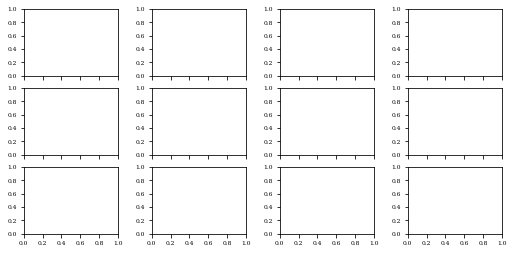

In [8]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.collections import PathCollection

# ─── User‐adjustable settings ──────────────────────────────────────────────────

# 1) Root of all SIMULATION folders:
method_path = "SIM_results"

# 2) The “case_name” subfolder to look under:
case_name = "case_NH3_counterflow_PCI_matrix"

# 3) Fixed mechanism folder name:
mech = "Otomo_32s213r"

# 4) The list of target cases to use:
target_case_assemble = [
    # 'N_CF_0',
    'N_CF_1',
    'N_CF_2',
    'N_CF_3',
    'N_CF_4',
    
    # (feel free to re‐enable others if needed)
]

# 5) Display names for each panel (can be identical to target_case names):
target_name_assemble = [
    # 'N_CF_0',
    'N_CF_1',
    'N_CF_2',
    'N_CF_3',
    'N_CF_4',
    
]

# 6) x‐ranges for each target case:
x_range_assemble = [
    [3, 8],
    [3, 8],
    [3, 8],
    [3, 8],
    [3, 8],
]

# 7) Line styles, colors, markers (cycled through):
line_arr = ('-','--','-.',':')
color_arr = ('k','r','b','y','g','c','m')
symbol_arr = ('s','o','v','^','*')

# ###################### Plot FIGURE RECONSTRUCT SPACE ######################
fig, axs = plt.subplots(
    3,
    len(target_case_assemble),
    figsize=(1.8 * len(target_case_assemble), 3.5),
    sharex=True
)

# Ensure axs is always 2D even if there's only one column
if len(target_case_assemble) == 1:
    axs = axs[:, np.newaxis]

# Columns to plot in each row
cols_1 = ['T',    'X_NH3', 'X_H2', 'X_O2', 'X_N2']
cols_2 = ['MF',   'X_OH',  'X_O',  'X_H',  'X_NO']
cols_3 = ['CEM',  'HRR']

# ─── User‐adjustable y‐limits for each variable ────────────────────────────────
cols_2_range = {
    'MF':   (0.0, 1.0),       # MF is always linear [0,1]
    'X_OH': (1.1e-4, 5e-2),
    'X_O':  (1.1e-4, 5e-2),
    'X_H':  (1.1e-4, 5e-2),
    'X_NO': (1.1e-4, 5e-2),
}

cols_3_range = {
    'CEM': (-5, 5),
    'HRR': (0, 4e9),
}


for j, target_case in enumerate(target_case_assemble):
    # ─── Read SIM (original) data for this mechanism ───────────────────────────
    sim_csv_path = os.path.join(method_path, case_name, mech, f"{target_case}.csv")
    if not os.path.isfile(sim_csv_path):
        print(f"  → File not found: {sim_csv_path}")
        continue

    df_sim = pd.read_csv(sim_csv_path)
    grid = df_sim['grid'].to_numpy() * 1000  # convert to mm

    # ─── Read reconstructed (QSSA) data for this mechanism ────────────────────
    qssa_path = os.path.join("figs", "QSSA", method_path, case_name, target_case, mech, "predicted_X.csv")
    if os.path.isfile(qssa_path):
        df_qssa = pd.read_csv(qssa_path)
    else:
        df_qssa = pd.DataFrame()

    # ─── Row 1: Plot cols_1 ──────────────────────────────────────────────────
    ax1 = axs[0, j]
    ax2 = ax1.twinx()

    for i, col in enumerate(cols_1):
        ls = line_arr[i % len(line_arr)]
        c = 'orange' if col == 'T' else color_arr[i % len(color_arr)]

        if col == 'T':
            # Plot temperature on the right axis
            if 'T' in df_sim.columns:
                ax2.plot(grid,
                         df_sim['T'].to_numpy(),
                         linestyle=ls, linewidth=2,
                         color='orange',
                         label='T')
        else:
            # Plot QSSA (reconstructed) on left, SIM scatter for comparison
            if col in df_qssa.columns:
                ax1.plot(grid,
                         df_qssa[col].to_numpy(),
                         linestyle=ls, linewidth=2,
                         color=c,
                         label=col)
            if col in df_sim.columns:
                ax1.scatter(grid[::3],
                            df_sim[col].to_numpy()[::3],
                            s=4, alpha=0.8,
                            marker='o',
                            color=c)

    # Set x and y limits for row 1
    ax1.set_xlim(x_range_assemble[j])
    ax2.set_xlim(x_range_assemble[j])
    ax1.set_ylim(0, 0.9)     # still hard‐coded for X‐species in row1
    ax2.set_ylim(0, 2500)

    # Y‐labeling and ticks for row 1
    if j == 0:
        ax1.set_ylabel('X', fontsize=6, color='black')
        ax1.tick_params(axis='y', labelleft=True, labelright=False, direction='in')
        ax2.tick_params(axis='y', labelleft=False, labelright=False)
    elif j == len(target_case_assemble) - 1:
        ax2.set_ylabel('T (K)', fontsize=6, color='red')
        # Combined legend inside the last panel
        handles2, labels2 = ax2.get_legend_handles_labels()
        handles1, labels1 = ax1.get_legend_handles_labels()
        combined_handles = handles2 + handles1
        combined_labels = labels2 + labels1
        legend = ax1.legend(combined_handles,
                            combined_labels,
                            loc='center right',
                            # bbox_to_anchor=(0.55, 0.55),
                            frameon=False,
                            fontsize=4)
        for text, line in zip(legend.get_texts(), legend.get_lines()):
            text.set_color(line.get_color())
        ax2.tick_params(axis='y', labelleft=False, colors='red', direction='in', labelright=True)
        ax1.tick_params(axis='y', labelleft=False, labelright=False)
    else:
        ax2.tick_params(axis='y', labelleft=False, labelright=False)
        ax1.tick_params(axis='y', labelleft=False, labelright=False)

    ax1.tick_params(axis='x', labelbottom=False)
    ax1.set_title(f"{target_name_assemble[j]}", fontsize=6)

    # ─── Row 2: Plot cols_2 ──────────────────────────────────────────────────
    ax1_2 = axs[1, j]
    ax2_2 = ax1_2.twinx()

    for i, col in enumerate(cols_2):
        ls = line_arr[i % len(line_arr)]
        # MF on left axis (black), all others on right axis (colored)
        if col == 'MF':
            if 'MF' in df_qssa.columns:
                ax1_2.plot(grid,
                           df_qssa['MF'].to_numpy(),
                           linestyle=ls, linewidth=1,
                           color='black',
                           label='MF')
            if 'MF' in df_sim.columns:
                ax1_2.scatter(grid,
                              df_sim['MF'].to_numpy(),
                              s=4, alpha=0.8,
                              marker=symbol_arr[i % len(symbol_arr)],
                              color='black')
        else:
            c = color_arr[i % len(color_arr)]
            if col in df_sim.columns:
                ax2_2.scatter(grid[::3],
                              df_sim[col].to_numpy()[::3],
                              s=4, alpha=0.8,
                              marker=symbol_arr[i % len(symbol_arr)],
                              color=c)
            if col in df_qssa.columns:
                ax2_2.plot(grid,
                           df_qssa[col].to_numpy(),
                           linestyle=ls, linewidth=1.2,
                           color=c,
                           label=col)

    # Set axis limits and log scale for row 2 using the dictionaries:
    ax1_2.set_xlim(x_range_assemble[j])
    ax2_2.set_xlim(x_range_assemble[j])

    # Left y‐limit for MF:
    y_min, y_max = cols_2_range['MF']
    ax1_2.set_ylim(y_min, y_max)

    # Right y‐limit for all other X‐species:
    # We know all non‐MF species share the same range in cols_2_range
    # (X_OH, X_O, X_H, X_NO). So just pick one of them:
    y_min2, y_max2 = cols_2_range['X_OH']
    ax2_2.set_ylim(y_min2, y_max2)
    ax2_2.set_yscale('log')

    # Y‐labeling and ticks for row 2
    if j == 0:
        ax1_2.set_ylabel('MF', fontsize=6, color='black')
        ax1_2.tick_params(axis='y', labelleft=True, colors='black', direction='in', labelright=False)
        ax2_2.tick_params(axis='y', labelleft=False, labelright=False, direction='in')
    elif j == len(target_case_assemble) - 1:
        ax2_2.set_ylabel('X', fontsize=6)
        # Combined legend inside the last panel for row 2
        h_ax2_2, l_ax2_2 = ax2_2.get_legend_handles_labels()
        h_ax1_2, l_ax1_2 = ax1_2.get_legend_handles_labels()
        combined_h2 = h_ax2_2 + h_ax1_2
        combined_l2 = l_ax2_2 + l_ax1_2
        legend_2 = ax1_2.legend(
            combined_h2,
            combined_l2,
            loc='center right',
            # bbox_to_anchor=(0.55, 0.55),
            frameon=False,
            fontsize=4
        )
        for text, line in zip(legend_2.get_texts(), legend_2.get_lines()):
            text.set_color(line.get_color())
        ax2_2.tick_params(axis='y', labelleft=False, direction='in', labelright=True)
        ax1_2.tick_params(axis='y', labelleft=False, labelright=False)
    else:
        ax1_2.tick_params(axis='y', labelleft=False, labelright=False)
        ax2_2.tick_params(axis='y', labelleft=False, labelright=False)

    ax1_2.tick_params(axis='x', labelbottom=False)

    # ─── Row 3: Plot cols_3 ──────────────────────────────────────────────────
    ax1_3 = axs[2, j]
    ax2_3 = ax1_3.twinx()

    legend_handles = []
    legend_labels = []

    for i, col in enumerate(cols_3):
        ls = line_arr[i % len(line_arr)]
        m = symbol_arr[j % len(symbol_arr)]
        # We want CEM in black on the left, HRR in red on the right
        if col == 'CEM':
            # Reconstructed CEM (line) and SIM scatter, both on left axis
            if 'CEM' in df_qssa.columns:
                ax1_3.plot(grid,
                           df_qssa['CEM'].to_numpy(),
                           linestyle=ls, linewidth=1,
                           color='k',
                           label='CEM')
            if 'CEM' in df_sim.columns:
                h_cem = ax1_3.scatter(grid[::2],
                                      df_sim['CEM'].to_numpy()[::2],
                                      s=4, alpha=0.8,
                                      marker=m,
                                      color='k')
                legend_handles.append(h_cem)
                legend_labels.append('CEM')

            # Apply the CEM y‐limit from cols_3_range:
            y1_min, y1_max = cols_3_range['CEM']
            ax1_3.set_ylim(y1_min, y1_max)

        elif col == 'HRR':
            # Reconstructed HRR (scatter) and SIM HRR (line), both on right axis,
            # with SIM divided by 1e9
            if 'HRR' in df_qssa.columns:
                ax2_3.scatter(grid[::2],
                              df_qssa['HRR'].to_numpy()[::2] / 1e9,
                              s=4, alpha=0.8,
                              marker=m,
                              color='r')
            if 'HRR' in df_sim.columns:
                h_hrr = ax2_3.plot(grid,
                                   df_sim['HRR'].to_numpy() / 1e9,
                                   linestyle=ls, linewidth=1.2,
                                   color='r',
                                   label='HRR')[0]
                legend_handles.append(h_hrr)
                legend_labels.append('HRR')

            # HRR range was (0, 4e9); after dividing by 1e9 it becomes (0, 4.0)
            y2_min, y2_max = cols_3_range['HRR']
            ax2_3.set_ylim(y2_min / 1e9, y2_max / 1e9)

    # Set axis limits for row 3
    ax1_3.set_xlim(x_range_assemble[j])
    ax2_3.set_xlim(x_range_assemble[j])

    # Y‐labeling and ticks for row 3
    if j == 0:
        ax1_3.set_ylabel('CEM', fontsize=6, color='black')
        ax1_3.tick_params(axis='y', labelleft=True, colors='black', direction='in', labelright=False)
        ax2_3.tick_params(axis='y', labelleft=False, labelright=False, direction='in')
    elif j == len(target_case_assemble) - 1:
        ax2_3.set_ylabel(r'HRR ($\times 10^{9}$)', fontsize=6, color='r')
        # Combined legend inside the last panel for row 3
        legend_3 = ax2_3.legend(handles=legend_handles,
                                 labels=legend_labels,
                                 loc='upper right',
                                #  bbox_to_anchor=(0.55, 0.55),
                                 frameon=False,
                                 fontsize=4)
        # for text, line in zip(legend_3.get_texts(), legend_3.get_lines()):
        #     # color text to match its handle
        #     if isinstance(line, Line2D):
        #         col_text = line.get_color()
        #     elif isinstance(line, PathCollection):
        #         col_text = line.get_facecolor()[0]
        #     else:
        #         col_text = line.get_edgecolor()[0]
        #     text.set_color(col_text)
        ax1_3.tick_params(axis='y', labelleft=False, labelright=False)
        ax2_3.tick_params(axis='y', labelleft=False, colors='r', direction='in', labelright=True)
    else:
        ax1_3.tick_params(axis='y', labelleft=False, labelright=False)
        ax2_3.tick_params(axis='y', labelleft=False, labelright=False)

    # X‐axis label on bottom row
    ax1_3.set_xlabel('x (mm)', fontsize=6)
    ax1_3.tick_params(axis='x', labelbottom=True)

plt.tight_layout()
# ─── Save the figure ───────────────────────────────────────────────────────────
fig_dir = "figs/NH3"
os.makedirs(fig_dir, exist_ok=True)
out_file = os.path.join(fig_dir, "1D_CEQ_NH3_combine_expanded.pdf")
plt.savefig(out_file, dpi=300, bbox_inches='tight')
print(f"→ Saved figure at: {out_file}")

# Figure 6: Compare Normalized HRR reconstruction of different cases using Otomo

ValueError: x and y must have same first dimension, but have shapes (172,) and (167,)

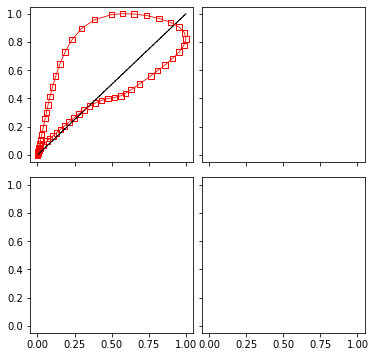

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ─── User‐adjustable settings ──────────────────────────────────────────────────
data_path             = "SIM_results"
row1_qssa_case_name   = "case_NH3_counterflow_KAUST"
row2_qssa_case_name   = "case_NH3_counterflow_KAUST_OH"
target_cases          = ["N_CF_1", "N_CF_2", "N_CF_3", "N_CF_4"]
# mech                  = "Otomo_32s213r"  # only Otomo here
mech                  = "Otomo_32s213r"  # only Otomo here


# ─── Plot‐style arrays ─────────────────────────────────────────────────────────
# Each entry: (legend_label, linestyle, color, marker)
series_info = [
    # y = x reference
    ("$y = x$",        "--",  "k",  None),
    # QSSA from the “normal” folder
    ("QSSA HRR (Baseline)", "-",   "r",  "s"),
    # QSSA from the “OH” folder
    ("QSSA HRR (With OH)",     "-",   "b",  "o"),
    # SIM (OH × NH₃)
    ("[OH][NH₃]",    "-",   "g",  "v"),
    # SIM NH
    ("[NH]",            "-",   "c",  "^"),
    # SIM OH
    ("[OH]",            "-",   "m",  "d"),
]

# ─── Create a 2×2 grid of subplots, sharing both X and Y, with small padding ──
n_rows, n_cols = 2, 2
fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(3 * n_cols, 3 * n_rows),
    sharex=True,
    sharey=True,
    gridspec_kw={'hspace': 0.1, 'wspace': 0.05}
)
axes = axes.flatten()  # so we can index subplots by a single index

def plot_one_subplot(ax, target_case):
    # 1) Load SIM data
    sim_csv = os.path.join(data_path, row1_qssa_case_name, mech, f"{target_case}.csv")
    if not os.path.isfile(sim_csv):
        raise FileNotFoundError(f"Simulation file not found:\n{sim_csv}")
    df_sim = pd.read_csv(sim_csv)

    # 2) Load QSSA from “normal”
    qssa1_csv = os.path.join(
        "figs", "QSSA", data_path, row1_qssa_case_name, target_case, mech, "predicted_X.csv"
    )
    if not os.path.isfile(qssa1_csv):
        raise FileNotFoundError(f"QSSA (normal) file not found:\n{qssa1_csv}")
    df_qssa1 = pd.read_csv(qssa1_csv)

    # 3) Load QSSA from “OH”
    qssa2_csv = os.path.join(
        "figs", "QSSA", data_path, row2_qssa_case_name, target_case, mech, "predicted_X.csv"
    )
    if not os.path.isfile(qssa2_csv):
        raise FileNotFoundError(f"QSSA (OH) file not found:\n{qssa2_csv}")
    df_qssa2 = pd.read_csv(qssa2_csv)

    # 4) Prepare SIM HRR (normalized)
    sim_hrr      = df_sim["HRR"].to_numpy()
    sim_hrr_norm = sim_hrr / np.max(sim_hrr)

    # 5) Build the (x, y) pairs in the same order as series_info
    variants = []
    # (a) y = x reference
    variants.append((sim_hrr_norm, sim_hrr_norm))
    # (b) QSSA1 HRR (baseline)
    qssa1_hrr_norm = df_qssa1["HRR"].to_numpy() / np.max(df_qssa1["HRR"].to_numpy())
    variants.append((qssa1_hrr_norm, sim_hrr_norm))
    # (c) QSSA2 HRR (with OH)
    qssa2_hrr_norm = df_qssa2["HRR"].to_numpy() / np.max(df_qssa2["HRR"].to_numpy())
    variants.append((qssa2_hrr_norm, sim_hrr_norm))
    # (d) SIM (OH × NH₃)
    prod_oh_nh3_norm = (df_sim["X_OH"].to_numpy() * df_sim["X_NH3"].to_numpy())
    prod_oh_nh3_norm /= np.max(prod_oh_nh3_norm)
    variants.append((prod_oh_nh3_norm, sim_hrr_norm))
    # (e) SIM NH
    sim_nh_norm = df_sim["X_NH"].to_numpy() / np.max(df_sim["X_NH"].to_numpy())
    variants.append((sim_nh_norm, sim_hrr_norm))
    # (f) SIM OH
    sim_oh_norm = df_sim["X_OH"].to_numpy() / np.max(df_sim["X_OH"].to_numpy())
    variants.append((sim_oh_norm, sim_hrr_norm))

    # 6) Plot each series
    for (label, ls, color, marker), (x_arr, y_arr) in zip(series_info, variants):
        if marker is None:
            ax.plot(x_arr, y_arr, linestyle=ls, color=color, linewidth=1)
        else:
            ax.plot(x_arr, y_arr, linestyle=ls, color=color, linewidth=0.8)
            ax.scatter(
                x_arr,
                y_arr,
                s=30,
                marker=marker,
                facecolors='none',    # hollow marker
                edgecolors=color,
                label=label
            )

    # 7) Finalize axes
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal', adjustable='box')

    # Force ticks at 0, 0.25, 0.5, 0.75, and 1
    ticks = [0, 0.25, 0.5, 0.75, 1]
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    # Only left‐column subplots get a y‐label and visible y‐tick labels
    idx = target_cases.index(target_case)
    col_index = idx % n_cols
    if col_index == 0:
        ax.set_ylabel("Normalized HRR", fontsize=8)
        ax.tick_params(axis='y', labelsize=6, left=True, labelleft=True)
        ax.set_yticklabels(['0', '0.25', '0.5', '0.75', '1'])
    else:
        ax.tick_params(axis='y', labelleft=False)

    # Only bottom‐row subplots get an x‐label and visible x‐tick labels
    row_index = idx // n_cols
    if row_index == n_rows - 1:
        ax.set_xlabel("Normalized variant", fontsize=8)
        ax.tick_params(axis='x', labelsize=6, bottom=True, labelbottom=True)
        ax.set_xticklabels(['0', '0.25', '0.5', '0.75', '1'])
    else:
        ax.tick_params(axis='x', labelbottom=False)

    # Put the case name inside the axes (lower‐right corner)
    ax.text(
        0.98, 0.02,
        target_case,
        transform=ax.transAxes,
        ha='right', va='bottom',
        fontsize=9
    )

# ─── Draw all subplots ─────────────────────────────────────────────────────────
for idx_case, target_case in enumerate(target_cases):
    plot_one_subplot(axes[idx_case], target_case)

# ─── Build a single external legend and place it above the subplots ───────────
proxy_handles = []
proxy_labels  = []
for (label, ls, color, marker) in series_info:
    if marker is None:
        ph = Line2D([0], [0], linestyle=ls, color=color, linewidth=1)
    else:
        ph = Line2D(
            [0], [0],
            linestyle=ls, color=color, marker=marker,
            markerfacecolor='none', markeredgecolor=color,  # hollow in legend
            markersize=6, linewidth=0.8
        )
    proxy_handles.append(ph)
    proxy_labels.append(label)

# Move legend to top-center.
fig.legend(
    proxy_handles,
    proxy_labels,
    loc='upper center',
    ncol=len(proxy_handles),
    frameon=False,
    fontsize=6,
    bbox_to_anchor=(0.5, 0.93)
)

# ─── Use tight layout and leave room for the top legend ────────────────────────
fig.tight_layout(rect=[0, 0, 1, 0.90])

out_dir = "figs/validation"
os.makedirs(out_dir, exist_ok=True)
save_path = os.path.join(out_dir, "HRR_vs_variants_2x2_with_quarter_ticks.pdf")
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"→ Saved figure with quarter‐interval ticks at: {save_path}")

# Compare Normalized Species

<ipython-input-10-7ecc056da776>:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.90])


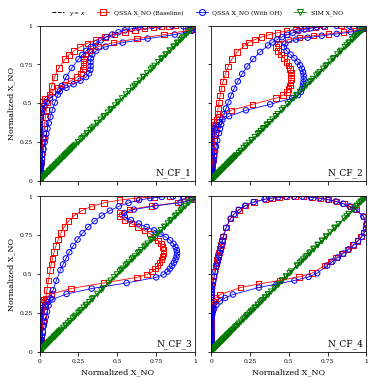

→ Saved X_NO comparison figure at: figs/validation/X_NO_comparison_2x2.pdf


In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ─── User‐adjustable settings ──────────────────────────────────────────────────
data_path             = "SIM_results"
row1_qssa_case_name   = "case_NH3_counterflow_KAUST"
row2_qssa_case_name   = "case_NH3_counterflow_KAUST_OH"
target_cases          = ["N_CF_1", "N_CF_2", "N_CF_3", "N_CF_4"]
mech                  = "Otomo_32s213r"  # only Otomo here

# ─── Plot‐style arrays ─────────────────────────────────────────────────────────
# Each entry: (legend_label, linestyle, color, marker)
series_info = [
    # y = x reference
    ("$y = x$",             "--",  "k",  None),
    # QSSA X_NO from the “normal” folder
    ("QSSA X_NO (Baseline)", "-",   "r",  "s"),
    # QSSA X_NO from the “OH” folder
    ("QSSA X_NO (With OH)",  "-",   "b",  "o"),
    # SIM X_NO
    ("SIM X_NO",            "-",   "g",  "v"),
]

# ─── Create a 2×2 grid of subplots, sharing both X and Y, with small padding ──
n_rows, n_cols = 2, 2
fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(3 * n_cols, 3 * n_rows),
    sharex=True,
    sharey=True,
    gridspec_kw={'hspace': 0.1, 'wspace': 0.05}
)
axes = axes.flatten()  # so we can index subplots by a single index

def plot_one_subplot(ax, target_case):
    # 1) Load SIM data
    sim_csv = os.path.join(data_path, row1_qssa_case_name, mech, f"{target_case}.csv")
    if not os.path.isfile(sim_csv):
        raise FileNotFoundError(f"Simulation file not found:\n{sim_csv}")
    df_sim = pd.read_csv(sim_csv)

    # 2) Load QSSA X_NO from “normal”
    qssa1_csv = os.path.join(
        "figs", "QSSA", data_path, row1_qssa_case_name, target_case, mech, "predicted_X.csv"
    )
    if not os.path.isfile(qssa1_csv):
        raise FileNotFoundError(f"QSSA (normal) file not found:\n{qssa1_csv}")
    df_qssa1 = pd.read_csv(qssa1_csv)

    # 3) Load QSSA X_NO from “OH”
    qssa2_csv = os.path.join(
        "figs", "QSSA", data_path, row2_qssa_case_name, target_case, mech, "predicted_X.csv"
    )
    if not os.path.isfile(qssa2_csv):
        raise FileNotFoundError(f"QSSA (OH) file not found:\n{qssa2_csv}")
    df_qssa2 = pd.read_csv(qssa2_csv)

    # 4) Prepare SIM X_NO (normalized)
    sim_x_no      = df_sim["X_NO"].to_numpy()
    sim_x_no_norm = sim_x_no / np.max(sim_x_no)

    # 5) Prepare QSSA X_NO (normalized)
    qssa1_x_no_norm = df_qssa1["X_NO"].to_numpy()
    qssa1_x_no_norm = qssa1_x_no_norm / np.max(qssa1_x_no_norm)
    qssa2_x_no_norm = df_qssa2["X_NO"].to_numpy()
    qssa2_x_no_norm = qssa2_x_no_norm / np.max(qssa2_x_no_norm)

    # 6) Build the (x, y) pairs in the same order as series_info
    variants = [
        (sim_x_no_norm, sim_x_no_norm),  # (a) y = x reference
        (qssa1_x_no_norm, sim_x_no_norm),# (b) QSSA1 X_NO vs SIM X_NO
        (qssa2_x_no_norm, sim_x_no_norm),# (c) QSSA2 X_NO vs SIM X_NO
        (sim_x_no_norm, sim_x_no_norm),  # (d) SIM X_NO vs SIM X_NO (for markers)
    ]

    # 7) Plot each series
    for (label, ls, color, marker), (x_arr, y_arr) in zip(series_info, variants):
        if marker is None:
            ax.plot(x_arr, y_arr, linestyle=ls, color=color, linewidth=1)
        else:
            ax.plot(x_arr, y_arr, linestyle=ls, color=color, linewidth=0.8)
            ax.scatter(
                x_arr,
                y_arr,
                s=30,
                marker=marker,
                facecolors='none',    # hollow marker
                edgecolors=color,
                label=label
            )

    # 8) Finalize axes
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal', adjustable='box')

    # Force ticks at 0, 0.25, 0.5, 0.75, and 1
    ticks = [0, 0.25, 0.5, 0.75, 1]
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    # Only left‐column subplots get a y‐label and visible y‐tick labels
    idx = target_cases.index(target_case)
    col_index = idx % n_cols
    if col_index == 0:
        ax.set_ylabel("Normalized X_NO", fontsize=8)
        ax.tick_params(axis='y', labelsize=6, left=True, labelleft=True)
        ax.set_yticklabels(['0', '0.25', '0.5', '0.75', '1'])
    else:
        ax.tick_params(axis='y', labelleft=False)

    # Only bottom‐row subplots get an x‐label and visible x‐tick labels
    row_index = idx // n_cols
    if row_index == n_rows - 1:
        ax.set_xlabel("Normalized X_NO", fontsize=8)
        ax.tick_params(axis='x', labelsize=6, bottom=True, labelbottom=True)
        ax.set_xticklabels(['0', '0.25', '0.5', '0.75', '1'])
    else:
        ax.tick_params(axis='x', labelbottom=False)

    # Put the case name inside the axes (lower‐right corner)
    ax.text(
        0.98, 0.02,
        target_case,
        transform=ax.transAxes,
        ha='right', va='bottom',
        fontsize=9
    )

# ─── Draw all subplots ─────────────────────────────────────────────────────────
for idx_case, target_case in enumerate(target_cases):
    plot_one_subplot(axes[idx_case], target_case)

# ─── Build a single external legend and place it above the subplots ───────────
proxy_handles = []
proxy_labels  = []
for (label, ls, color, marker) in series_info:
    if marker is None:
        ph = Line2D([0], [0], linestyle=ls, color=color, linewidth=1)
    else:
        ph = Line2D(
            [0], [0],
            linestyle=ls, color=color, marker=marker,
            markerfacecolor='none', markeredgecolor=color,  # hollow in legend
            markersize=6, linewidth=0.8
        )
    proxy_handles.append(ph)
    proxy_labels.append(label)

# Move legend to top-center.
fig.legend(
    proxy_handles,
    proxy_labels,
    loc='upper center',
    ncol=len(proxy_handles),
    frameon=False,
    fontsize=6,
    bbox_to_anchor=(0.5, 0.93)
)

# ─── Use tight layout and leave room for the top legend ────────────────────────
fig.tight_layout(rect=[0, 0, 1, 0.90])

out_dir = "figs/validation"
os.makedirs(out_dir, exist_ok=True)
save_path = os.path.join(out_dir, "X_NO_comparison_2x2.pdf")
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"→ Saved X_NO comparison figure at: {save_path}")

# Add the Pearson Correlation plot of different cases using Otomo

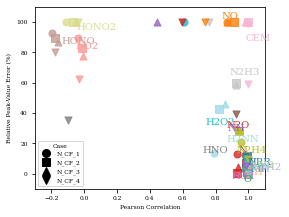

Scatter saved to figs/NH3_NP_CF/pearson_vs_peak_error_labels_OH.pdf


In [11]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse

def plot_corr_vs_peak_error(sim_case_dir,
                            recon_case_dir,
                            mechanism,
                            fig_dir,
                            target_cases,
                            data_species,        # list of strings
                            pdf_name,
                            cmap_name='tab20',
                            min_peak_threshold=1e-6,
                            label_offsets=None):
    if label_offsets is None:
        label_offsets = {}

    # 1) load N_0 to threshold & order
    df_sim_N0   = pd.read_csv(Path(sim_case_dir) /mechanism/ "N_CF_1.csv")
    sp_peaks_N0 = {sp: df_sim_N0[sp].max() for sp in data_species}
    filtered    = [sp for sp in data_species
                   if sp_peaks_N0.get(sp, 0) >= min_peak_threshold]
    ordered_sp  = sorted(filtered,
                         key=lambda sp: sp_peaks_N0[sp],
                         reverse=True)

    # 2) build color & marker maps
    cases = target_cases
    cmap  = plt.get_cmap(cmap_name)
    species_colors = {sp: cmap(i / len(ordered_sp)) for i, sp in enumerate(ordered_sp)}
    marker_list = ['o','s','^','v','<','>','P','X','D','*','h','+','x','|','_']
    case_markers = {case: marker_list[i % len(marker_list)] for i, case in enumerate(cases)}

    # 3) collect data
    records = []
    for case in cases:
        df_sim   = pd.read_csv(Path(sim_case_dir) / mechanism /f"{case}.csv")
        recon_p  = Path(recon_case_dir) / case / mechanism / "predicted_X.csv"
        df_recon = pd.read_csv(recon_p) if recon_p.is_file() else None

        for sp in ordered_sp:
            tp = df_sim[sp].max()
            rp = df_recon[sp].max() if df_recon is not None else np.nan
            err = (abs(rp - tp)/abs(tp)*100) if tp!=0 else np.nan
            err = min(err,100)

            tvals = df_sim[sp].values
            rvals = df_recon[sp].values if df_recon is not None else np.full_like(tvals, np.nan)
            m = min(len(tvals), len(rvals))
            tvals, rvals = tvals[:m], rvals[:m]
            corr = pearsonr(tvals, rvals)[0] if m>1 and not np.isnan(tvals).any() and not np.isnan(rvals).any() else np.nan

            records.append((case, sp, corr, err))

    df = pd.DataFrame(records, columns=['case','species','corr','error'])

    # 4) plot
    fig, ax = plt.subplots(figsize=(4,3))
    species_centroids = {}

    for case, group in df.groupby('case'):
        for sp, sub in group.groupby('species'):
            ax.scatter(sub['corr'], sub['error'],
                       color=species_colors[sp],
                       marker=case_markers[case],
                       s=50, alpha=0.8)
            # accumulate centroids
            c = (sub['corr'].mean(), sub['error'].mean())
            species_centroids.setdefault(sp, []).append(c)

    # draw ellipses + inline labels
    for sp, pts in species_centroids.items():
        xs, ys = zip(*pts)
        xc, yc = np.mean(xs), np.mean(ys)
        w = (max(xs)-min(xs))*1  or 0.05
        h = (max(ys)-min(ys))*1.2 or 5.0

        color = species_colors[sp]

        dx, dy = label_offsets.get(sp, (-w/2, 0))
        # Remove the "X_" from the species name for better labeling
        sp_name = sp.replace("X_", "")  # Remove the "X_" prefix
        ax.text(xc+dx, yc+dy, sp_name,
                fontsize=10, color=color,
                ha='left', va='center', alpha=1)

    ax.set_xlabel('Pearson Correlation')
    ax.set_ylabel('Relative Peak‐Value Error (%)')
    ax.set_xlim(-0.3, 1.1)
    ax.set_ylim(-10, 110)

    # Case‐marker legend only
    case_handles = [
        Line2D([0],[0],
               marker=case_markers[c],
               color='k', linestyle='',
               markersize=8, label=c)
        for c in cases
    ]
    ax.legend(handles=case_handles,
              title='Case',
              bbox_to_anchor=(0,0),
              loc='lower left')

    plt.tight_layout()
    os.makedirs(fig_dir, exist_ok=True)
    outpath = Path(fig_dir) / pdf_name
    plt.savefig(outpath, format='pdf')
    plt.show()
    plt.close()
    print(f'Scatter saved to {outpath}')

plot_corr_vs_peak_error(
    sim_case_dir="SIM_results/case_NH3_counterflow_KAUST",
    recon_case_dir="figs/QSSA/SIM_results/case_NH3_counterflow_KAUST_OH",
    mechanism="Otomo_32s213r",
    fig_dir="figs/NH3_NP_CF",
    target_cases=["N_CF_1","N_CF_2","N_CF_3", "N_CF_4"],
    data_species=[
        "X_NO","X_H","X_O","X_OH","X_HO2","X_H2O2","X_NH2","X_NH","X_N","X_NNH","X_NH2OH",
        "X_H2NO","X_HNOH","X_HNO","X_HON","X_NO2","X_HONO","X_HNO2","X_NO3","X_HONO2",
        "X_N2O","X_N2H4","X_N2H3","X_N2H2","X_H2NN","MF","HRR", "CEM"
    ],
    pdf_name="pearson_vs_peak_error_labels_OH.pdf",
    cmap_name='tab20',
    min_peak_threshold=1e-6,
    label_offsets={
    'X_H':   (0.03,  0),
    'X_O':   (-0.03, -4),
    'X_OH':  (0.03,  3),
    'X_NO2':  (-0.03,  6),
    'X_N2O':  (0.02,  3),
    'X_HONO2':  (0.02,  -3),
    'X_N2H3':  (0,  5),
    'X_NH2':  (0.01,  5),
    'X_N2H2':  (0.02,  0),
    'X_NH':  (0.02,  0),
    'X_N2H4':  (-0.03,  -6),
    'X_H2NN':  (0,  -4),
    'X_HONO':  (0.04,  0),
    'X_NO':  (-0.01,  4),
    'Qdot':  (0.03,  4),
    'X_HO2':  (-0.1,  -4),
    'X_H2O2':  (-0.15,  4),
    'X_HNO':  (0,  6),
    'MF':  (0.01,  3),
}
)

# 做一个放大效果吧！

    label_offsets={
    'X_H':   (0.03,  0),
    'X_O':   (-0.03, -4),
    'X_OH':  (0.03,  3),
    'X_NO2':  (-0.03,  6),
    'X_N2O':  (0.02,  3),
    'X_HONO2':  (0.02,  -3),
    'X_N2H3':  (0,  5),
    'X_NH2':  (0.01,  5),
    'X_N2H2':  (0.02,  0),
    'X_NH':  (0.02,  0),
    'X_N2H4':  (-0.03,  -6),
    'X_H2NN':  (0,  -4),
    'X_HONO':  (0.04,  0),
    'X_NO':  (-0.01,  4),
    'Qdot':  (0.03,  4),
    'X_HO2':  (-0.1,  -4),
    'X_H2O2':  (-0.15,  4),
    'X_HNO':  (0,  6),
    'MF':  (0.01,  3),
}



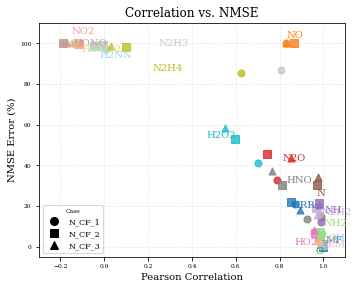

Scatter saved to figs/NH3_NP_CF/corr_vs_peak_error.pdf


In [12]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse
import re

def plot_corr_vs_peak_error(
    sim_case_dir: str,
    recon_case_dir: str,
    mechanism: str,
    fig_dir: str,
    target_cases: list,
    data_species: list,        # list of strings
    pdf_name: str,
    cmap_name: str = 'tab20',
    min_peak_threshold: float = 1e-6,
    label_offsets: dict = None,
    error_type: str = "peak"   # either "peak" or "nmse"
):
    """
    Plots, for each species:
      – Pearson correlation between SIM vs. QSSA time‐series (x‐axis)
      – either relative peak‐value error (%) or NMSE (%) (y‐axis)
      
    Parameters
    ----------
    sim_case_dir:    root folder where SIM CSVs live, e.g. "SIM_results/case_NH3_counterflow_KAUST"
    recon_case_dir:  root folder for QSSA CSVs, e.g. "figs/QSSA/SIM_results/case_NH3_counterflow_KAUST"
    mechanism:       name of mechanism subfolder (e.g. "Otomo_32s213r")
    fig_dir:         where to save the PDF
    target_cases:    list of case names, e.g. ["N_CF_1","N_CF_2","N_CF_3"]
    data_species:    list of species columns to include (strings)
    pdf_name:        output PDF filename (e.g. "pearson_vs_error.pdf")
    cmap_name:       name of a Matplotlib colormap for coloring species
    min_peak_threshold:
                     only include species whose peak in SIM N0 exceeds this
    label_offsets:   dict mapping species → (dx, dy) for text annotations
    error_type:      "peak" for relative peak‐value error (%),
                     "nmse" for normalized MSE (%) across the entire profile
    """
    if label_offsets is None:
        label_offsets = {}

    # 1) Load “N_CF_1.csv” (SIM) to decide which species pass the threshold
    df_sim_N0 = pd.read_csv(Path(sim_case_dir) / mechanism / "N_CF_1.csv")
    sp_peaks_N0 = {sp: df_sim_N0.get(sp, pd.Series([])).max() for sp in data_species}
    filtered    = [sp for sp in data_species if sp_peaks_N0.get(sp, 0) >= min_peak_threshold]
    ordered_sp  = sorted(filtered, key=lambda sp: sp_peaks_N0[sp], reverse=True)

    # 2) Build color & marker maps
    cmap  = plt.get_cmap(cmap_name)
    species_colors = {sp: cmap(i / len(ordered_sp)) for i, sp in enumerate(ordered_sp)}
    marker_list = ['o','s','^','v','<','>','P','X','D','*','h','+','x','|','_']
    case_markers = {case: marker_list[i % len(marker_list)] for i, case in enumerate(target_cases)}

    # 3) Collect Pearson r and error for each (case, species)
    records = []
    for case in target_cases:
        # 3a) Load SIM for this case
        sim_csv = Path(sim_case_dir) / mechanism / f"{case}.csv"
        if not sim_csv.is_file():
            raise FileNotFoundError(f"Simulation file not found:\n{sim_csv}")
        df_sim = pd.read_csv(sim_csv)

        # 3b) Load QSSA for this case
        recon_p = Path(recon_case_dir) / case / mechanism / "predicted_X.csv"
        df_recon = pd.read_csv(recon_p) if recon_p.is_file() else None

        for sp in ordered_sp:
            # 3c) Peak-based error:
            tvals = df_sim.get(sp, pd.Series([])).values
            rvals = df_recon.get(sp, pd.Series(np.nan * np.ones_like(tvals))).values if df_recon is not None else np.full_like(tvals, np.nan)

            # If either has no data, skip
            if tvals.size == 0 or rvals.size == 0:
                continue

            # 3d) Compute “peak” error if requested
            peak_sim = np.nanmax(tvals)
            peak_recon = np.nanmax(rvals)
            if error_type == "peak":
                if peak_sim == 0:
                    err = np.nan
                else:
                    err = abs(peak_recon - peak_sim) / abs(peak_sim) * 100.0
                    err = min(err, 100.0)

            # 3e) Compute NMSE if requested
            elif error_type == "nmse":
                # Truncate to equal length if necessary
                m = min(tvals.size, rvals.size)
                t_arr = tvals[:m]
                r_arr = rvals[:m]
                # If SIM is all zero, skip
                denom = np.nanmean(t_arr**2)
                if denom <= 0:
                    err = np.nan
                else:
                    mse = np.nanmean((r_arr - t_arr) ** 2)
                    nmse = mse / denom * 100.0
                    err = nmse
                    err = min(err, 100.0)
            else:
                raise ValueError("error_type must be either 'peak' or 'nmse'")

            # 3f) Compute Pearson r between t_arr and r_arr
            if tvals.size != rvals.size:
                m = min(tvals.size, rvals.size)
                t_arr = tvals[:m]
                r_arr = rvals[:m]
            else:
                t_arr = tvals
                r_arr = rvals

            if t_arr.size < 2 or np.all(np.isnan(t_arr)) or np.all(np.isnan(r_arr)):
                corr = np.nan
            else:
                # If constant, Pearson is undefined
                if np.nanstd(t_arr) == 0 or np.nanstd(r_arr) == 0:
                    corr = np.nan
                else:
                    corr = pearsonr(t_arr, r_arr)[0]

            records.append((case, sp, corr, err))

    df = pd.DataFrame(records, columns=['case', 'species', 'corr', 'error'])

    # 4) Plot
    fig, ax = plt.subplots(figsize=(5, 4))
    species_centroids = {}

    for case, group in df.groupby('case'):
        for sp, sub in group.groupby('species'):
            ax.scatter(
                sub['corr'], sub['error'],
                color=species_colors[sp],
                marker=case_markers[case],
                s=50, alpha=0.8
            )
            # accumulate centroids
            c = (sub['corr'].mean(), sub['error'].mean())
            species_centroids.setdefault(sp, []).append(c)

    # Draw (optional) ellipses around each species cluster, then label
    for sp, pts in species_centroids.items():
        xs, ys = zip(*pts)
        xc, yc = np.nanmean(xs), np.nanmean(ys)
        w = (np.nanmax(xs) - np.nanmin(xs)) * 1.0 or 0.05
        h = (np.nanmax(ys) - np.nanmin(ys)) * 1.2 or 5.0
        color = species_colors[sp]
        # If you want an ellipse, uncomment these two lines:
        # ell = Ellipse((xc, yc), w, h,
        #               edgecolor=color, facecolor='none', lw=1, alpha=0.6)
        # ax.add_patch(ell)

        dx, dy = label_offsets.get(sp, (-w/2, 0))
        sp_name = sp.replace("X_", "")
        ax.text(
            xc + dx, yc + dy, sp_name,
            fontsize=10, color=color,
            ha='left', va='center', alpha=1
        )

    # 5) Axes labels
    ax.set_xlabel("Pearson Correlation", fontsize=10)
    if error_type == "peak":
        ax.set_ylabel("Relative Peak‐Value Error (%)", fontsize=10)
        ax.set_ylim(-10, 110)
    else:  # nmse
        ax.set_ylabel("NMSE Error (%)", fontsize=10)
        ax.set_ylim(-5, np.nanmax(df['error']) * 1.1)

    ax.set_xlim(-0.3, 1.1)
    ax.set_title("Correlation vs. " + ("Peak Error" if error_type=="peak" else "NMSE"), fontsize=12)
    ax.grid(True, linestyle=":", alpha=0.5)

    # 6) Case‐marker legend (only markers for each case)
    case_handles = [
        Line2D(
            [0], [0],
            marker=case_markers[c],
            color='k', linestyle='',
            markersize=8, label=c
        )
        for c in target_cases
    ]
    ax.legend(
        handles=case_handles,
        title='Case',
        bbox_to_anchor=(0, 0),
        loc='lower left',
        fontsize=8
    )

    plt.tight_layout()
    os.makedirs(fig_dir, exist_ok=True)
    outpath = Path(fig_dir) / pdf_name
    plt.savefig(outpath, format='pdf')
    plt.show()
    plt.close()
    print(f"Scatter saved to {outpath}")


# ─── Example usage ─────────────────────────────────────────────────────────────
plot_corr_vs_peak_error(
    sim_case_dir    = "SIM_results/case_NH3_counterflow_KAUST",
    recon_case_dir  = "figs/QSSA/SIM_results/case_NH3_counterflow_KAUST",
    mechanism       = "Otomo_32s213r",
    fig_dir         = "figs/NH3_NP_CF",
    target_cases    = ["N_CF_1", "N_CF_2", "N_CF_3"],
    data_species    = [
        "X_NO","X_H","X_O","X_OH","X_HO2","X_H2O2","X_NH2","X_NH",
        "X_N","X_NNH","X_NH2OH","X_H2NO","X_HNOH","X_HNO","X_HON",
        "X_NO2","X_HONO","X_HNO2","X_NO3","X_HONO2","X_N2O","X_N2H4",
        "X_N2H3","X_N2H2","X_H2NN","MF","HRR","CEM"
    ],
    pdf_name        = "corr_vs_peak_error.pdf",
    cmap_name       = 'tab20',
    min_peak_threshold = 1e-6,
    label_offsets={
    'X_H':   (0.03,  0),
    'X_O':   (-0.03, -4),
    'X_OH':  (0.03,  3),
    'X_NO2':  (-0.03,  6),
    'X_N2O':  (0.02,  3),
    'X_HONO2':  (0.02,  -3),
    'X_N2H3':  (0,  5),
    'X_NH2':  (0.01,  5),
    'X_N2H2':  (0.02,  0),
    'X_NH':  (0.02,  0),
    'X_N2H4':  (-0.03,  -6),
    'X_H2NN':  (0,  -4),
    'X_HONO':  (0.04,  0),
    'X_NO':  (-0.01,  4),
    'Qdot':  (0.03,  4),
    'X_HO2':  (-0.1,  -4),
    'X_H2O2':  (-0.15,  4),
    'X_HNO':  (0,  6),
    'MF':  (0.01,  3),
},
    error_type = "nmse"   # "peak" or "nmse"
)

### Add the reaction path way analysis,(No Need)
### Add the time scale analysis (No Need)

# Figure 8: 完成不同掺氢比，掺氮气比的画图吧

‼️ Very large NMSE detected: case=N_CF_NH3_0.48_H2_0.12_N2_0.40 denom=1.032e+18 mse=1.119e+27 nmse%=1.084e+11
  sim_arr[:5] = [-1.11118995e-09 -1.13280410e-09  1.71575563e-09  6.80406031e-08
  2.24094837e-06]
  qssa_arr[:5]= [-3.08111080e-42 -4.54618722e-42 -3.86790750e-41 -8.09609525e-40
 -1.73040488e-38]


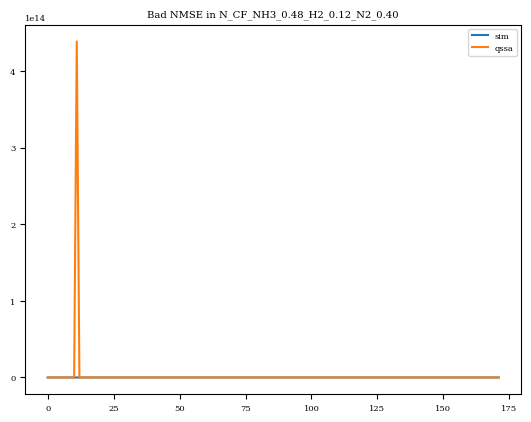

‼️ Very large NMSE detected: case=N_CF_NH3_0.54_H2_0.06_N2_0.40 denom=6.588e+17 mse=1.359e+22 nmse%=2.062e+06
  sim_arr[:5] = [-3.17969633e-07  3.04809994e-07  4.24512510e-04  1.81287601e-06
  3.63637965e-09]
  qssa_arr[:5]= [1.92934018e-08 4.25454979e-05 4.99273134e-07 3.69377108e-08
 1.10137373e-08]


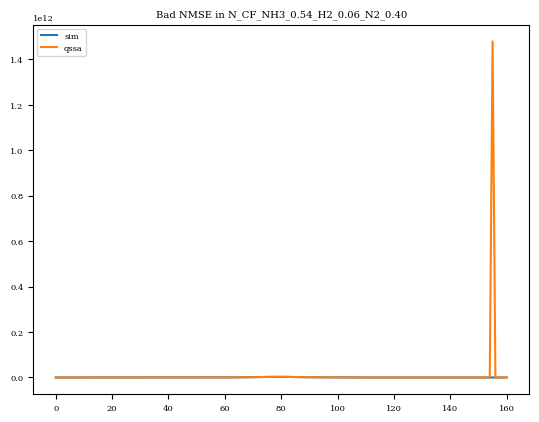

‼️ Very large NMSE detected: case=N_CF_NH3_0.64_H2_0.16_N2_0.20 denom=1.369e+18 mse=1.721e+24 nmse%=1.257e+08
  sim_arr[:5] = [5.30459562e+02 8.30090713e-05 3.73618434e-07 1.84974224e-05
 2.00972656e-04]
  qssa_arr[:5]= [2.04652274e-03 3.45293747e+01 1.18445888e-08 2.51881184e-09
 1.09942929e-08]


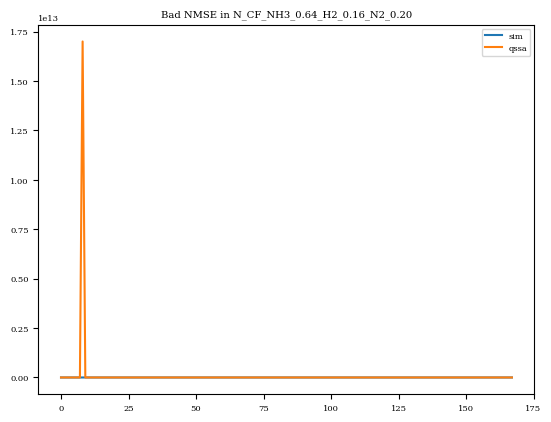

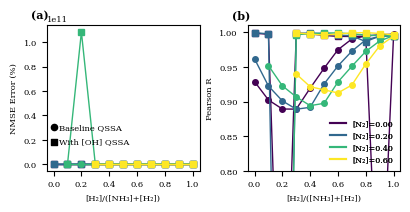

→ Saved combined subplot at: figs/validation/nmse_error_and_corr_vs_H2ratio.pdf


In [26]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import math
import matplotlib.ticker as mticker

def plot_error_and_corr_by_N2(
    base_sim_dir: str,
    base_qssa_dir: str,
    base_qssa_2_dir: str,
    mechanism: str,
    error_type: str = "peak",      # "peak" or "nmse"
    temp_threshold: float = 500.0,
    out_dir: str = "figs/validation"
):
    """
    Scan subfolders under `base_qssa_dir` & `_2_dir`, extract SIM vs QSSA,
    compute errors/correlations, and plot vs H2-ratio.
    """

    def parse_case_name(case_name: str):
        m = re.match(r".*NH3_([0-9.]+)_H2_([0-9.]+)_N2_([0-9.]+)", case_name)
        if not m:
            raise ValueError(f"Cannot parse fractions from '{case_name}'")
        return float(m.group(1)), float(m.group(2)), float(m.group(3))

    def list_valid_cases(qssa_root):
        if not os.path.isdir(qssa_root):
            return []
        return sorted(d for d in os.listdir(qssa_root)
                      if os.path.isdir(os.path.join(qssa_root, d)))

    def accumulate_metrics(qssa_root, case_list, errors_dict, corr_dict):
        for case_name in case_list:
            try:
                nh3, h2, n2 = parse_case_name(case_name)
            except ValueError:
                continue
            if nh3 + h2 == 0:
                continue
            h2_ratio = h2 / (nh3 + h2)

            sim_csv_path  = os.path.join(base_sim_dir,  mechanism, f"{case_name}.csv")
            qssa_csv_path = os.path.join(qssa_root, case_name, mechanism, "predicted_X.csv")
            if not (os.path.isfile(sim_csv_path) and os.path.isfile(qssa_csv_path)):
                continue

            df_sim  = pd.read_csv(sim_csv_path)
            df_qssa = pd.read_csv(qssa_csv_path)

            if "T" not in df_sim.columns or df_sim["T"].max() <= temp_threshold:
                continue
            if "HRR" not in df_sim.columns or "HRR" not in df_qssa.columns:
                continue

            sim_hrr_full  = df_sim["HRR"].to_numpy()
            qssa_hrr_full = df_qssa["HRR"].to_numpy()

            # Length mismatch if >2 points difference
            if abs(sim_hrr_full.size - qssa_hrr_full.size) > 2:
                print("⚠️ length mismatch", case_name,
                      sim_hrr_full.size, qssa_hrr_full.size)

            # Align
            if sim_hrr_full.size != qssa_hrr_full.size:
                nmin = min(sim_hrr_full.size, qssa_hrr_full.size)
                sim_arr  = sim_hrr_full[:nmin]
                qssa_arr = qssa_hrr_full[:nmin]
            else:
                sim_arr, qssa_arr = sim_hrr_full, qssa_hrr_full

            # Relative peak error
            peak_sim, peak_qssa = sim_arr.max(), qssa_arr.max()
            if peak_sim == 0:
                continue
            rel_peak_error = (peak_qssa - peak_sim)/peak_sim*100.0

            # NMSE
            denom = np.nanmean(sim_arr**2)
            if denom <= 0:
                nmse_error = np.nan
            else:
                mse = np.nanmean((qssa_arr - sim_arr)**2)
                nmse_error = mse/denom*100.0

                # Debug huge NMSE
                if error_type=="nmse" and not np.isnan(nmse_error) and nmse_error>1e6:
                    print("‼️ Very large NMSE detected:",
                          f"case={case_name}",
                          f"denom={denom:.3e}",
                          f"mse={mse:.3e}",
                          f"nmse%={nmse_error:.3e}")
                    print("  sim_arr[:5] =", sim_arr[:5])
                    print("  qssa_arr[:5]=", qssa_arr[:5])
                    plt.figure()
                    plt.plot(sim_arr, label="sim")
                    plt.plot(qssa_arr, label="qssa")
                    plt.title(f"Bad NMSE in {case_name}")
                    plt.legend()
                    plt.show()

            # Pearson R
            if sim_arr.size<2 or np.all(sim_arr==sim_arr[0]) or np.all(qssa_arr==qssa_arr[0]):
                continue
            pearson_r = np.corrcoef(sim_arr, qssa_arr)[0,1]

            chosen_error = rel_peak_error if error_type=="peak" else nmse_error
            errors_dict.setdefault(n2, []).append((h2_ratio, chosen_error))
            corr_dict.setdefault(n2, []).append((h2_ratio, pearson_r))

    # Gather cases
    cases1 = list_valid_cases(base_qssa_dir)
    cases2 = list_valid_cases(base_qssa_2_dir)

    # Pre-check mismatches
    for case_name in cases1:
        sim_path  = os.path.join(base_sim_dir,  mechanism, f"{case_name}.csv")
        qssa_path = os.path.join(base_qssa_dir, case_name, mechanism, "predicted_X.csv")
        if os.path.isfile(sim_path) and os.path.isfile(qssa_path):
            a = pd.read_csv(sim_path)["HRR"].size
            b = pd.read_csv(qssa_path)["HRR"].size
            if abs(a-b)>2:
                print("💥 Pre-check length mismatch", case_name, a, b)

    errors1_by_n2, corr1_by_n2 = {}, {}
    errors2_by_n2, corr2_by_n2 = {}, {}

    accumulate_metrics(base_qssa_dir,  cases1, errors1_by_n2, corr1_by_n2)
    accumulate_metrics(base_qssa_2_dir, cases2, errors2_by_n2, corr2_by_n2)

    # Collect N2 fractions
    unique_n2 = sorted(set(errors1_by_n2) | set(errors2_by_n2))
    if not unique_n2:
        print("No valid cases found; exiting.")
        return

    # Plot setup
    fig, (ax_err, ax_corr) = plt.subplots(1, 2, figsize=(4, 2), sharey=False)
    cmap = plt.get_cmap("viridis")
    max_idx = max(1, len(unique_n2)-1)

    # Left: error
    for idx, n2 in enumerate(unique_n2):
        color = cmap(idx/max_idx)
        # Baseline: solid line + 'o' marker
        if n2 in errors1_by_n2:
            arr = np.array(errors1_by_n2[n2])
            h2, e = arr[:,0], arr[:,1]
            order = np.argsort(h2)
            ax_err.plot(h2[order], e[order],
                        linestyle='-', marker='o',
                        color=color, linewidth=1.0, markersize=4)
        # With OH: solid line + 's' marker
        if n2 in errors2_by_n2:
            arr = np.array(errors2_by_n2[n2])
            h2, e = arr[:,0], arr[:,1]
            order = np.argsort(h2)
            ax_err.plot(h2[order], e[order],
                        linestyle='-', marker='s',
                        color=color, linewidth=1.0, markersize=4)

    if error_type=="peak":
        ax_err.axhline(0, linestyle="--", linewidth=0.8, color="k")

    ax_err.set_xlabel("[H₂]/([NH₃]+[H₂])", fontsize=6)
    ax_err.set_ylabel(
        "Relative Peak-Value Error (%)" if error_type=="peak" else "NMSE Error (%)",
        fontsize=6
    )
    ax_err.tick_params(labelsize=6)

    # Right: Pearson R
    for idx, n2 in enumerate(unique_n2):
        color = cmap(idx/max_idx)
        # Baseline
        if n2 in corr1_by_n2:
            arr = np.array(corr1_by_n2[n2])
            h2, r = arr[:,0], arr[:,1]
            order = np.argsort(h2)
            ax_corr.plot(h2[order], r[order],
                         linestyle='-', marker='o',
                         color=color, linewidth=1.0, markersize=4)
        # With OH
        if n2 in corr2_by_n2:
            arr = np.array(corr2_by_n2[n2])
            h2, r = arr[:,0], arr[:,1]
            order = np.argsort(h2)
            ax_corr.plot(h2[order], r[order],
                         linestyle='-', marker='s',
                         color=color, linewidth=1.0, markersize=4)
    ax_corr.yaxis.set_major_locator(mticker.MaxNLocator(5))
    ax_corr.set_xlabel("[H₂]/([NH₃]+[H₂])", fontsize=6)
    ax_corr.set_ylabel("Pearson R", fontsize=6)
    ax_corr.set_ylim(0.8, 1.01)
    ax_corr.tick_params(labelsize=6)

    # Color legend
    handles, labels = [], []
    for idx, n2 in enumerate(unique_n2):
        handles.append(Line2D([0],[0], color=cmap(idx/max_idx), linewidth=1.5))
        labels.append(f"[N₂]={n2:.2f}")
    ncol = max(1, math.ceil(len(unique_n2)/4))
    leg = ax_corr.legend(
        handles, labels, loc="lower right",
        frameon=False, ncol=ncol,
        fontsize=5.8, title_fontsize=6
    )
    ax_corr.add_artist(leg)

    # Line-style labels
    # Baseline QSSA: circle marker
    ax_err.scatter(
        [0.05], [0.3],
        marker='o', color='k',
        transform=ax_err.transAxes,
        s=20, zorder=4
    )
    ax_err.text(
        0.08, 0.3, "Baseline QSSA",
        transform=ax_err.transAxes,
        fontsize=6, va="center", ha="left"
    )

    # With [OH] QSSA: square marker
    ax_err.scatter(
        [0.05], [0.2],
        marker='s', color='k',
        transform=ax_err.transAxes,
        s=20, zorder=4
    )
    ax_err.text(
        0.08, 0.2, "With [OH] QSSA",
        transform=ax_err.transAxes,
        fontsize=6, va="center", ha="left"
    )
    ax_err.text(-0.1, 1.05, "(a)", transform=ax_err.transAxes,
                fontsize=8, fontweight="bold")
    ax_corr.text(-0.1, 1.05, "(b)", transform=ax_corr.transAxes,
                fontsize=8, fontweight="bold")
    
    plt.tight_layout(pad=0.4)
    os.makedirs(out_dir, exist_ok=True)
    fname = "peak_error_and_corr_vs_H2ratio.pdf" if error_type=="peak" else "nmse_error_and_corr_vs_H2ratio.pdf"
    plt.savefig(os.path.join(out_dir, fname), dpi=300, bbox_inches="tight")
    plt.show()
    print(f"→ Saved combined subplot at: {os.path.join(out_dir, fname)}")


# Example usage
if __name__ == "__main__":
    plot_error_and_corr_by_N2(
        base_sim_dir="SIM_results/case_NH3_counterflow_PCI_matrix",
        base_qssa_dir="figs/QSSA/SIM_results/case_NH3_counterflow_PCI_matrix_ori",
        base_qssa_2_dir="figs/QSSA/SIM_results/case_NH3_counterflow_PCI_matrix_OH",
        mechanism="Mei_39s256r", # "Otomo_32s213r", "NUIG_39s306r", "Han_35s177r", "Marshall_33s221r", "KAUST_32s243r", "Mei_39s256r"
        error_type="nmse",      # "peak" or "nmse"
        temp_threshold=400.0,
        out_dir="figs/validation"
    )

# Figure 9:The flux distribution of different cases

Do for the non-vitiated case    

In [3]:
from typing import Tuple, List, Dict, Optional, Set

def plot_fluxes_single_panel(
    edges,
    edge_labels=None,
    root_dir="figs/QSSA/SIM_results/case_NH3_counterflow_PCI_matrix",
    subdir="Otomo_32s213r",
    dot_name="O_rxnpath.dot",
    out_path="figs/reaction_flux/oh_fluxes_combined.pdf",
    panels=None,
    panel_round=2,
    symbols=None,
    cmap_name="plasma",
    figsize=(5, 4),
    xlabel=r"[H$_2$]/([NH$_3$]+[H$_2$])",
    ylabel="Normalized Net Flux",
    title=None,
    show=False,
    dpi=300,
    save_formats=("pdf","png"),
    fill_default_edge_labels=True,

    # --- NEW: debug knobs ---
    debug=False,
    debug_mech=None,                       # e.g., "Mei_39s256r"
    debug_edges_idx: Optional[List[int]] = None,  # e.g., [1] to focus on 2nd edge
    debug_h2r_targets: Optional[List[float]] = None,  # e.g., [0.90]
    debug_tol=1e-3,                        # tolerance for matching H2 ratio

    # --- NEW: choose flux source ---
    flux_metric: str = "label",            # "label" (leading number) or "net" (fwd - rev)
):
    """
    Plot multiple reaction net flux curves in one panel across N2 'panels' (line colors).
    Also supports verbose debugging for specific mechanisms, edges, and H2 ratios.

    flux_metric:
      - "label": use the leading numeric value in the DOT label (e.g., 0.812)
      - "net":   use (fwd - rev)
    """
    import os, re
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    # --- helpers --------------------------------------------------------------
    def parse_case_name(case_name: str) -> Tuple[float, float, float]:
        m = re.match(r'.*NH3_([0-9.]+)_H2_([0-9.]+)_N2_([0-9.]+)', case_name)
        if not m:
            raise ValueError(f"Bad case name '{case_name}'")
        return float(m.group(1)), float(m.group(2)), float(m.group(3))

    num_rx = r'([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)'

    def grab_flux(dot_path: str, src: str, dst: str):
        """
        Return (value, label_val, fwd, rev, found, metric_used)
        - value: the number used for plotting (per flux_metric)
        - label_val: first number in label (if present)
        - fwd/rev: parsed fwd/rev (if present)
        """
        if not os.path.isfile(dot_path):
            if debug:
                print(f"[DBG] DOT missing: {dot_path}")
            return 0.0, None, None, None, False, None

        text = open(dot_path, "r").read()
        edge_rx = re.compile(rf'{re.escape(src)}\s*->\s*{re.escape(dst)}\s*\[(.*?)\];', re.DOTALL)
        em = edge_rx.search(text)
        if not em:
            if debug:
                print(f"[DBG] Edge not found in DOT: {src} -> {dst} in {dot_path}")
            return 0.0, None, None, None, False, None

        body = em.group(1)

        # label leading number
        label_val = None
        lab_m = re.search(r'label\s*=\s*"(.*?)"', body, re.DOTALL)
        if lab_m:
            lab = lab_m.group(1)
            first_num = re.search(num_rx, lab)
            if first_num:
                try:
                    label_val = float(first_num.group(1))
                except ValueError:
                    label_val = None

        # fwd / rev (for debug and optional "net" metric)
        fwd = rev = None
        fwd_m = re.search(rf'fwd:\s*{num_rx}', body)
        rev_m = re.search(rf'rev:\s*{num_rx}', body)
        if fwd_m: fwd = float(fwd_m.group(1))
        if rev_m: rev = float(rev_m.group(1))

        # choose value to return
        if flux_metric == "label":
            val = label_val if (label_val is not None) else ((fwd - rev) if (fwd is not None and rev is not None) else 0.0)
            metric_used = "label" if (label_val is not None) else ("net" if (fwd is not None and rev is not None) else None)
        else:  # "net"
            val = (fwd - rev) if (fwd is not None and rev is not None) else (label_val if label_val is not None else 0.0)
            metric_used = "net" if (fwd is not None and rev is not None) else ("label" if label_val is not None else None)

        return val, label_val, fwd, rev, True, metric_used

    # --- defaults / validation ------------------------------------------------
    edges = list(edges)
    if fill_default_edge_labels:
        edge_labels = [f"{s} → {d}" for (s, d) in edges]
    else:
        edge_labels = [""] * len(edges)

    symbols = ['^', 'o', 'v', 's', 'D', 'P', '*']
    def sym(i): return symbols[i % len(symbols)]

    # Debug config
    dbg_edges_mask = set(debug_edges_idx or range(len(edges)))
    dbg_h2r_targets = debug_h2r_targets or []

    # --- collect data ---------------------------------------------------------
    data: Dict[Tuple[float, Tuple[str, str]], List[Tuple[float, float]]] = {}
    detected_n2: Set[float] = set()

    for case in sorted(os.listdir(root_dir)):
        d = os.path.join(root_dir, case)
        if not os.path.isdir(d):
            continue

        # extincted? (max T < 500)
        extincted = False
        pred_csv = os.path.join(d, subdir, "predicted_X.csv")
        if os.path.isfile(pred_csv):
            try:
                df_pred = pd.read_csv(pred_csv)
                if "T" in df_pred.columns and df_pred["T"].max() < 500:
                    extincted = True
                    if debug:
                        print(f"[DBG] Extincted: {case} (max T < 500 K) → plotting NaN")
            except Exception as e:
                if debug:
                    print(f"[DBG] Could not read {pred_csv}: {e}")

        try:
            nh3, h2, n2 = parse_case_name(case)
        except ValueError:
            continue

        n2r = round(n2, panel_round)
        detected_n2.add(n2r)

        denom = nh3 + h2
        h2r = h2 / denom if denom > 0 else 0.0

        dot_path = os.path.join(d, subdir, dot_name)

        dbg_this_case = (
            debug and (debug_mech is None or subdir == debug_mech) and
            (not dbg_h2r_targets or any(abs(h2r - t) <= debug_tol for t in dbg_h2r_targets))
        )
        if dbg_this_case:
            print(f"[DBG] Case: {case} | subdir={subdir} | dot={os.path.basename(dot_path)} | "
                  f"H2/(NH3+H2)={h2r:.4f} | N2={n2:.2f} | extincted={extincted}")

        for idx, e in enumerate(edges):
            val, label_val, fwd, rev, found, metric_used = grab_flux(dot_path, *e)
            yval = np.nan if extincted else val
            data.setdefault((n2r, e), []).append((h2r, yval))

            if dbg_this_case and idx in dbg_edges_mask:
                tag = f"edge#{idx+1} {e[0]}->{e[1]}"
                if not found:
                    print(f"   [DBG] {tag}: NOT FOUND → value=0.0 (returned)")
                else:
                    pieces = []
                    if label_val is not None: pieces.append(f"label={label_val:.4g}")
                    if (fwd is not None) and (rev is not None): pieces.append(f"fwd={fwd:.4g}, rev={rev:.4g}, net={(fwd-rev):.4g}")
                    pieces.append(f"used={metric_used}, plotted={'NaN' if np.isnan(yval) else f'{yval:.4g}'}")
                    print("   [DBG] " + tag + ": " + " | ".join(pieces))

    # choose panels
    if panels is None:
        panels = sorted(detected_n2)
    else:
        panels = [round(v, panel_round) for v in panels]

    if len(panels) == 0:
        raise RuntimeError("No panels (N₂ fractions) found. Check root_dir/subdir/dot_name/case names.")

    # --- plotting -------------------------------------------------------------
    import matplotlib.pyplot as plt
    import numpy as np
    fig, ax = plt.subplots(figsize=figsize)

    for n2 in panels:
        for i_edge, edge in enumerate(edges):
            pts = np.array(data.get((n2, edge), []), dtype=float)
            if pts.size == 0:
                continue
            order = np.argsort(pts[:, 0])
            x, y = pts[order, 0], pts[order, 1]
            col = "tab:blue" if i_edge < 3 else "tab:red"
            ax.plot(x, y, linestyle='-', color=col,
                    marker=sym(i_edge), markersize=6, linewidth=1.2)

    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    if title is not None:
        ax.set_title(title, fontsize=11)
    ax.tick_params(labelsize=10)
    ax.grid(True, axis='y', alpha=0.2)

    # Legend
    react_handles = [
        Line2D([0],[0], color=("tab:blue" if i < 3 else "tab:red"),
               marker=sym(i), linestyle='-', markersize=6, label=edge_labels[i])
        for i in range(len(edges))
    ]
    ax.legend(handles=react_handles, loc='lower right',
              bbox_to_anchor=(0.68, 0.2), frameon=False, fontsize=8)

    # Save / show
    if out_path:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        base, _ = os.path.splitext(out_path)
        for ext in save_formats:
            path = f"{base}.{ext}"
            fig.savefig(path, dpi=dpi, bbox_inches="tight")
            print("→ saved figure:", path)

    if show:
        plt.show()
    else:
        plt.close(fig)

    return fig, ax


# REview Figure 

→ saved figure: figs/reaction_flux/Otomo_32s213r_O_following_fluxes_N2-0.20.pdf
→ saved figure: figs/reaction_flux/Otomo_32s213r_O_following_fluxes_N2-0.20.png


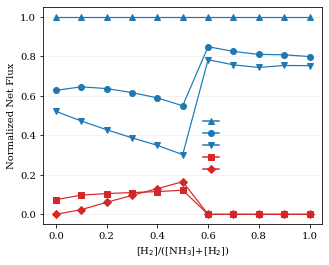

→ saved figure: figs/reaction_flux/Mei_39s256r_O_following_fluxes_N2-0.20.pdf
→ saved figure: figs/reaction_flux/Mei_39s256r_O_following_fluxes_N2-0.20.png


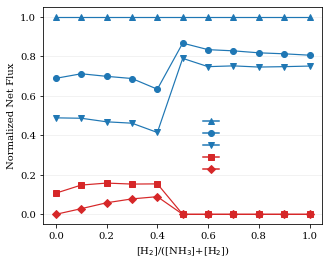

→ saved figure: figs/reaction_flux/NUIG_39s306r_O_following_fluxes_N2-0.20.pdf
→ saved figure: figs/reaction_flux/NUIG_39s306r_O_following_fluxes_N2-0.20.png


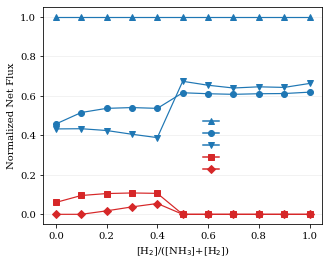

→ saved figure: figs/reaction_flux/Han_35s177r_O_following_fluxes_N2-0.20.pdf
→ saved figure: figs/reaction_flux/Han_35s177r_O_following_fluxes_N2-0.20.png


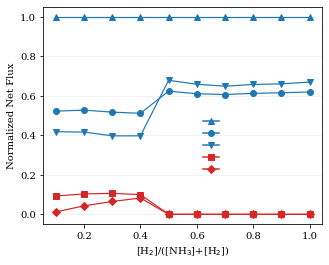

→ saved figure: figs/reaction_flux/Marshall_33s221r_O_following_fluxes_N2-0.20.pdf
→ saved figure: figs/reaction_flux/Marshall_33s221r_O_following_fluxes_N2-0.20.png


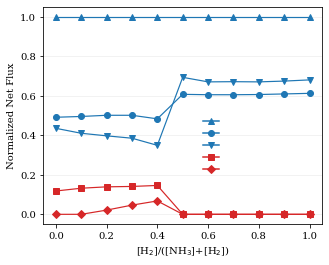

→ saved figure: figs/reaction_flux/KAUST_32s243r_O_following_fluxes_N2-0.20.pdf
→ saved figure: figs/reaction_flux/KAUST_32s243r_O_following_fluxes_N2-0.20.png


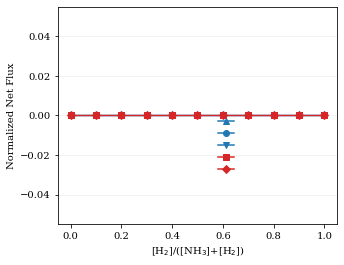

In [4]:
from typing import Dict, List, Tuple

# Shared labels
LABELS_6 = [
    r"OH $\to$ H$_2$O",
    r"O $\to$ OH",
    r"O$_2$ $\to$ O",
    r"O$_2$ $\to$ OH",
    r"OH $\to$ HNO",
    r"OH $\to$ NO",
]
LABELS_5 = [
    r"OH $\to$ H$_2$O",
    r"O $\to$ OH",
    r"O$_2$ $\to$ OH",
    r"OH $\to$ HNO",
    r"OH $\to$ NO",
]

# Only keep per-mechanism edges (order matches the labels above)
MECH_EDGES: Dict[str, List[Tuple[str, str]]] = {
    "Otomo_32s213r":    [("s6","s9"), ("s5","s6"),  ("s3","s6"), ("s6","s18"), ("s6","s0")],
    "Mei_39s256r":      [("s4","s5"), ("s3","s4"), ("s8","s4"), ("s4","s22"), ("s4","s19")],
    "NUIG_39s306r":     [("s12","s0"), ("s11","s12"), ("s5","s12"), ("s12","s25"), ("s12","s2")],         # 5 edges
    "Han_35s177r":      [("s4","s5"), ("s2","s4"), ("s3","s4"), ("s4","s18"), ("s4","s14")],              # 5 edges
    "Marshall_33s221r": [("s9","s11"), ("s8","s9"), ("s5","s9"), ("s9","s30"), ("s9","s2")],
    "KAUST_32s243r":    [("s3","s4"), ("s2","s3"),("s7","s3"), ("s3","s24"), ("s3","s21")],
}

# Build the full config compactly
MECH_CONFIG: Dict[str, Dict[str, List]] = {
    mech: {
        "edges": edges,
        "labels": (LABELS_6 if len(edges) == 6 else LABELS_5)
    }
    for mech, edges in MECH_EDGES.items()
}


# ── 3) shared plotting settings ──────────────────────────────────────────────
ROOT_DIR = "figs/QSSA/SIM_results/case_NH3_counterflow_PCI_matrix_ori"
DOT_NAME = "O_rxnpath.dot"
SYMBOLS  = ['^','o','v','s','D']
PANELS   = [0.20]
# PANELS   = [0, 0.20, 0.40, 0.60]

FIGSIZE  = (5, 4)
XLAB     = r"[H$_2$]/([NH$_3$]+[H$_2$])"
YLAB     = "Normalized Net Flux"
OUT_DIR  = "figs/reaction_flux"

import os
os.makedirs(OUT_DIR, exist_ok=True)

# ── 4) loop through mechanisms (save + display) ──────────────────────────────
for mech, cfg in MECH_CONFIG.items():
    edges       = cfg["edges"]
    edge_labels = cfg["labels"]

    panel_tag = "auto" if PANELS is None else "_".join(f"{p:.2f}" for p in PANELS)
    out_path = os.path.join(OUT_DIR, f"{mech}_O_following_fluxes_N2-{panel_tag}.pdf")

    plot_fluxes_single_panel(
        edges=edges,
        edge_labels=edge_labels,
        subdir=mech,
        root_dir=ROOT_DIR,
        dot_name=DOT_NAME,
        symbols=SYMBOLS,
        out_path=out_path,
        # title=mech,      # << set to None
        title=None,      # << set to None
        
        panels=PANELS,
        figsize=FIGSIZE,
        xlabel=XLAB,
        ylabel=YLAB,
        show=True,
        dpi=300,
        save_formats=("pdf","png"),
        fill_default_edge_labels=False,
        # debug=True,
        # debug_mech="Mei_39s256r",
        # debug_edges_idx=[1],        # 2nd edge in your list = ("s3","s4") = O -> OH
        # debug_h2r_targets=[0.90],   # look around 0.90
        # debug_tol=5e-3,             # allow small float slop (±0.005)
        # flux_metric="label",
    
    )


In [5]:
from typing import Tuple, List, Dict, Optional, Set

def plot_fluxes_single_panel(
    edges,
    edge_labels=None,
    root_dir="figs/QSSA/SIM_results/case_NH3_counterflow_PCI_matrix",
    subdir="Otomo_32s213r",
    dot_name="O_rxnpath.dot",
    out_path="figs/reaction_flux/oh_fluxes_combined.pdf",
    panels=None,
    panel_round=2,
    symbols=None,
    cmap_name="plasma",
    figsize=(5, 4),
    xlabel=None,                      # <- let us set automatically below
    ylabel="Normalized Net Flux",
    title=None,
    show=False,
    dpi=300,
    save_formats=("pdf","png"),
    fill_default_edge_labels=True,

    # --- NEW: x-axis selection ---
    x_mode: str = "h2ratio",          # "h2ratio" (old behavior) or "n2" (new)

    # --- NEW: debug knobs ---
    debug=False,
    debug_mech=None,
    debug_edges_idx: Optional[List[int]] = None,
    debug_h2r_targets: Optional[List[float]] = None,
    debug_tol=1e-3,

    # --- NEW: choose flux source ---
    flux_metric: str = "label",
):
    """
    Plot multiple reaction net flux curves in one panel across 'panels'.
    When x_mode='h2ratio', x = H2/(NH3+H2) and panels = distinct N2 fractions (old behavior).
    When x_mode='n2',      x = N2 fraction and panels = distinct H2 ratios (new behavior).
    """
    import os, re
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    # --- helpers --------------------------------------------------------------
    def parse_case_name(case_name: str) -> Tuple[float, float, float]:
        m = re.match(r'.*NH3_([0-9.]+)_H2_([0-9.]+)_N2_([0-9.]+)', case_name)
        if not m:
            raise ValueError(f"Bad case name '{case_name}'")
        return float(m.group(1)), float(m.group(2)), float(m.group(3))

    num_rx = r'([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)'

    def grab_flux(dot_path: str, src: str, dst: str):
        # (unchanged)
        import re, os
        if not os.path.isfile(dot_path):
            if debug:
                print(f"[DBG] DOT missing: {dot_path}")
            return 0.0, None, None, None, False, None
        text = open(dot_path, "r").read()
        edge_rx = re.compile(rf'{re.escape(src)}\s*->\s*{re.escape(dst)}\s*\[(.*?)\];', re.DOTALL)
        em = edge_rx.search(text)
        if not em:
            if debug:
                print(f"[DBG] Edge not found in DOT: {src} -> {dst} in {dot_path}")
            return 0.0, None, None, None, False, None
        body = em.group(1)
        label_val = None
        lab_m = re.search(r'label\s*=\s*"(.*?)"', body, re.DOTALL)
        if lab_m:
            lab = lab_m.group(1)
            first_num = re.search(num_rx, lab)
            if first_num:
                try:
                    label_val = float(first_num.group(1))
                except ValueError:
                    label_val = None
        fwd = rev = None
        fwd_m = re.search(rf'fwd:\s*{num_rx}', body)
        rev_m = re.search(rf'rev:\s*{num_rx}', body)
        if fwd_m: fwd = float(fwd_m.group(1))
        if rev_m: rev = float(rev_m.group(1))
        if flux_metric == "label":
            val = label_val if (label_val is not None) else ((fwd - rev) if (fwd is not None and rev is not None) else 0.0)
            metric_used = "label" if (label_val is not None) else ("net" if (fwd is not None and rev is not None) else None)
        else:
            val = (fwd - rev) if (fwd is not None and rev is not None) else (label_val if label_val is not None else 0.0)
            metric_used = "net" if (fwd is not None and rev is not None) else ("label" if label_val is not None else None)
        return val, label_val, fwd, rev, True, metric_used

    # --- defaults / validation ------------------------------------------------
    edges = list(edges)
    if fill_default_edge_labels:
        edge_labels = [f"{s} → {d}" for (s, d) in edges]
    else:
        edge_labels = edge_labels or [""] * len(edges)

    symbols = symbols or ['^', 'o', 'v', 's', 'D', 'P', '*']
    def sym(i): return symbols[i % len(symbols)]

    dbg_edges_mask = set(debug_edges_idx or range(len(edges)))
    dbg_h2r_targets = debug_h2r_targets or []

    # --- collect data ---------------------------------------------------------
    # Keying depends on x_mode
    #  - "h2ratio": key = (N2, edge) ; store (H2ratio, value)
    #  - "n2":      key = (H2ratio, edge) ; store (N2, value)
    data: Dict[Tuple[float, Tuple[str, str]], List[Tuple[float, float]]] = {}
    detected_n2: Set[float] = set()
    detected_h2r: Set[float] = set()

    for case in sorted(os.listdir(root_dir)):
        d = os.path.join(root_dir, case)
        if not os.path.isdir(d):
            continue

        # Extinction check
        extincted = False
        pred_csv = os.path.join(d, subdir, "predicted_X.csv")
        if os.path.isfile(pred_csv):
            try:
                df_pred = pd.read_csv(pred_csv)
                if "T" in df_pred.columns and df_pred["T"].max() < 500:
                    extincted = True
                    if debug:
                        print(f"[DBG] Extincted: {case} (max T < 500 K)")
            except Exception as e:
                if debug:
                    print(f"[DBG] Could not read {pred_csv}: {e}")

        try:
            nh3, h2, n2 = parse_case_name(case)
        except ValueError:
            continue

        denom = nh3 + h2
        h2r_raw = (h2 / denom) if denom > 0 else 0.0
        h2r = round(h2r_raw, panel_round)
        n2r = round(n2, panel_round)

        detected_n2.add(n2r)
        detected_h2r.add(h2r)

        dot_path = os.path.join(d, subdir, dot_name)

        dbg_this_case = (
            debug and (debug_mech is None or subdir == debug_mech) and
            (not dbg_h2r_targets or any(abs(h2r_raw - t) <= debug_tol for t in dbg_h2r_targets))
        )
        if dbg_this_case:
            print(f"[DBG] Case: {case} | H2/(NH3+H2)={h2r_raw:.4f} (bin={h2r:.2f}) | N2={n2r:.2f} | extincted={extincted}")

        for idx, e in enumerate(edges):
            val, label_val, fwd, rev, found, metric_used = grab_flux(dot_path, *e)
            yval = np.nan if extincted else val

            if x_mode == "n2":
                key = (h2r, e)              # panel = H2ratio
                xval = n2r                  # x = N2
            else:
                key = (n2r, e)              # panel = N2 (old behavior)
                xval = h2r_raw              # x = continuous H2 ratio

            data.setdefault(key, []).append((xval, yval))

            if dbg_this_case and idx in dbg_edges_mask:
                tag = f"edge#{idx+1} {e[0]}->{e[1]}"
                used = "NaN" if np.isnan(yval) else f"{yval:.4g}"
                print(f"   [DBG] {tag}: plotted={used}")

    # choose panels based on x_mode
    if panels is None:
        panels = sorted(detected_h2r) if x_mode == "n2" else sorted(detected_n2)
    else:
        panels = [round(v, panel_round) for v in panels]

    if len(panels) == 0:
        raise RuntimeError("No panels found. Check case names / directories.")

    # --- plotting -------------------------------------------------------------
    import matplotlib.pyplot as plt
    import numpy as np
    fig, ax = plt.subplots(figsize=figsize)

    for p in panels:
        for i_edge, edge in enumerate(edges):
            pts = np.array(data.get((p, edge), []), dtype=float)
            if pts.size == 0:
                continue
            order = np.argsort(pts[:, 0])
            x, y = pts[order, 0], pts[order, 1]
            col = "tab:blue" if i_edge < 3 else "tab:red"
            ax.plot(x, y, linestyle='-', color=col,
                    marker=sym(i_edge), markersize=6, linewidth=1.2)

    # default axis label if not provided
    if xlabel is None:
        xlabel = (r"[N$_2$] (dilution)" if x_mode == "n2"
                  else r"[H$_2$]/([NH$_3$]+[H$_2$])")

    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    if title is not None:
        ax.set_title(title, fontsize=11)
    ax.tick_params(labelsize=10)
    ax.grid(True, axis='y', alpha=0.2)

    # Legend (pathways)
    react_handles = [
        Line2D([0],[0], color=("tab:blue" if i < 3 else "tab:red"),
               marker=sym(i), linestyle='-', markersize=6, label=edge_labels[i])
        for i in range(len(edges))
    ]
    ax.legend(handles=react_handles, loc='lower right',
              bbox_to_anchor=(0.68, 0.2), frameon=False, fontsize=8)

    # Save / show
    if out_path:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        base, _ = os.path.splitext(out_path)
        for ext in save_formats:
            path = f"{base}.{ext}"
            fig.savefig(path, dpi=dpi, bbox_inches="tight")
            print("→ saved figure:", path)

    if show:
        plt.show()
    else:
        plt.close(fig)

    return fig, ax


→ saved figure: figs/reaction_flux/Otomo_32s213r_O_following_fluxes_vsN2-H2r0.80.pdf
→ saved figure: figs/reaction_flux/Otomo_32s213r_O_following_fluxes_vsN2-H2r0.80.png


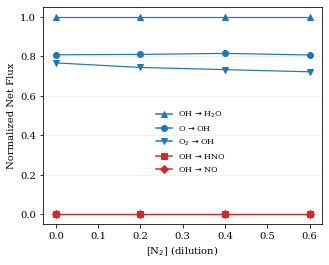

In [16]:
from typing import Dict, List, Tuple
import os

# (labels and MECH_EDGES unchanged)
LABELS_6 = [
    r"OH $\to$ H$_2$O",
    r"O $\to$ OH",
    r"O$_2$ $\to$ O",
    r"O$_2$ $\to$ OH",
    r"OH $\to$ HNO",
    r"OH $\to$ NO",
]
LABELS_5 = [
    r"OH $\to$ H$_2$O",
    r"O $\to$ OH",
    r"O$_2$ $\to$ OH",
    r"OH $\to$ HNO",
    r"OH $\to$ NO",
]

MECH_EDGES: Dict[str, List[Tuple[str, str]]] = {
    "Otomo_32s213r":    [("s6","s9"), ("s5","s6"),  ("s3","s6"), ("s6","s18"), ("s6","s0")],
    # "Mei_39s256r":      [("s4","s5"), ("s3","s4"), ("s8","s4"), ("s4","s22"), ("s4","s19")],
    # "NUIG_39s306r":     [("s12","s0"), ("s11","s12"), ("s5","s12"), ("s12","s25"), ("s12","s2")],
    # "Han_35s177r":      [("s4","s5"), ("s2","s4"), ("s3","s4"), ("s4","s18"), ("s4","s14")],
    # "Marshall_33s221r": [("s9","s11"), ("s8","s9"), ("s5","s9"), ("s9","s30"), ("s9","s2")],
    # "KAUST_32s243r":    [("s3","s4"), ("s2","s3"), ("s7","s3"), ("s3","s24"), ("s3","s21")],
}

MECH_CONFIG: Dict[str, Dict[str, List]] = {
    mech: {"edges": edges, "labels": (LABELS_6 if len(edges) == 6 else LABELS_5)}
    for mech, edges in MECH_EDGES.items()
}

# ── settings for N2 on x-axis ────────────────────────────────────────────────
ROOT_DIR = "figs/QSSA/SIM_results/case_NH3_counterflow_PCI_matrix_ori"
DOT_NAME = "O_rxnpath.dot"
SYMBOLS  = ['^','o','v','s','D']
# PANELS_H2 = [0.00, 0.20, 0.40, 0.60]         # <- fixed H2 ratios become panels
PANELS_H2 = [0.8]         # <- fixed H2 ratios become panels

FIGSIZE  = (5, 4)
XLAB     = r"[N$_2$] (dilution)"             # <- x-axis label
YLAB     = "Normalized Net Flux"
OUT_DIR  = "figs/reaction_flux"

os.makedirs(OUT_DIR, exist_ok=True)

for mech, cfg in MECH_CONFIG.items():
    edges       = cfg["edges"]
    edge_labels = cfg["labels"]

    panel_tag = "_".join(f"H2r{p:.2f}" for p in PANELS_H2)
    out_path = os.path.join(OUT_DIR, f"{mech}_O_following_fluxes_vsN2-{panel_tag}.pdf")

    plot_fluxes_single_panel(
        edges=edges,
        edge_labels=edge_labels,
        subdir=mech,
        root_dir=ROOT_DIR,
        dot_name=DOT_NAME,
        symbols=SYMBOLS,
        out_path=out_path,
        title=None,
        panels=PANELS_H2,          # <- panels are H2 ratios now
        panel_round=2,             # binning precision for H2 ratio
        figsize=FIGSIZE,
        xlabel=XLAB,
        ylabel=YLAB,
        x_mode="n2",               # <- NEW: plot vs N2
        show=True,
        dpi=300,
        save_formats=("pdf","png"),
        fill_default_edge_labels=False,
        # flux_metric="label",
        # debug=True,
        # debug_mech="Mei_39s256r",
        # debug_edges_idx=[1],
    )
